In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import normaltest, skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

In [24]:
df = pd.read_csv('df_merged.csv')
df

,month,CO2ppm,Temp,Humid,VPD,Chl_a,Chl_b,TChl,Car,Chl_a_b,...,DF_abs,SFI_abs,Fv-Fm,Leaf_ExtractionYield,Root_ExtractionYield,Leaf_TPC,Root_TPC,Leaf_TFC,Root_TFC,scenario
0,5,381.681033,16.918639,83.130786,1.532512,8.79,2.22,11.00,2.97,3.97,...,0.328,0.215,0.830,19.00,18.90,7.476,6.270,5.217,0.861,SSP1
1,5,374.463441,16.922124,83.096722,1.532868,8.99,2.56,11.55,3.09,3.52,...,0.287,0.199,0.826,20.10,19.60,7.369,6.396,5.257,0.836,SSP1
2,5,371.850683,16.930256,82.488003,1.534584,9.66,2.44,12.10,3.11,3.96,...,0.384,0.229,0.828,20.70,20.40,7.369,6.396,5.242,0.841,SSP1
3,5,400.475202,16.921511,82.081632,1.534512,9.33,2.45,11.79,3.13,3.80,...,0.503,0.282,0.839,19.00,18.90,7.476,6.270,5.217,0.861,SSP1
4,5,381.360788,16.921323,83.888666,1.531475,10.53,2.58,13.11,3.37,4.08,...,0.304,0.203,0.832,20.10,19.60,7.369,6.396,5.257,0.836,SSP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,9,1208.463000,25.901000,60.192000,2.560000,2.64,0.52,3.15,1.07,5.09,...,-0.626,0.051,0.722,7.10,14.60,7.743,5.277,1.455,0.513,SSP5
401,9,1211.911000,25.896000,60.254000,2.559000,4.74,1.12,5.86,1.53,4.22,...,-0.829,0.046,0.588,7.05,14.55,7.760,5.245,1.450,0.507,SSP5
402,9,1206.015000,25.923000,59.125000,2.565000,2.52,0.08,2.60,1.38,31.49,...,-0.879,0.037,0.643,7.00,14.50,7.814,5.324,1.460,0.518,SSP5
403,9,1225.166000,25.890000,55.446000,2.571000,2.63,0.39,3.02,1.17,6.73,...,-0.478,0.067,0.727,7.10,14.60,7.743,5.277,1.455,0.513,SSP5


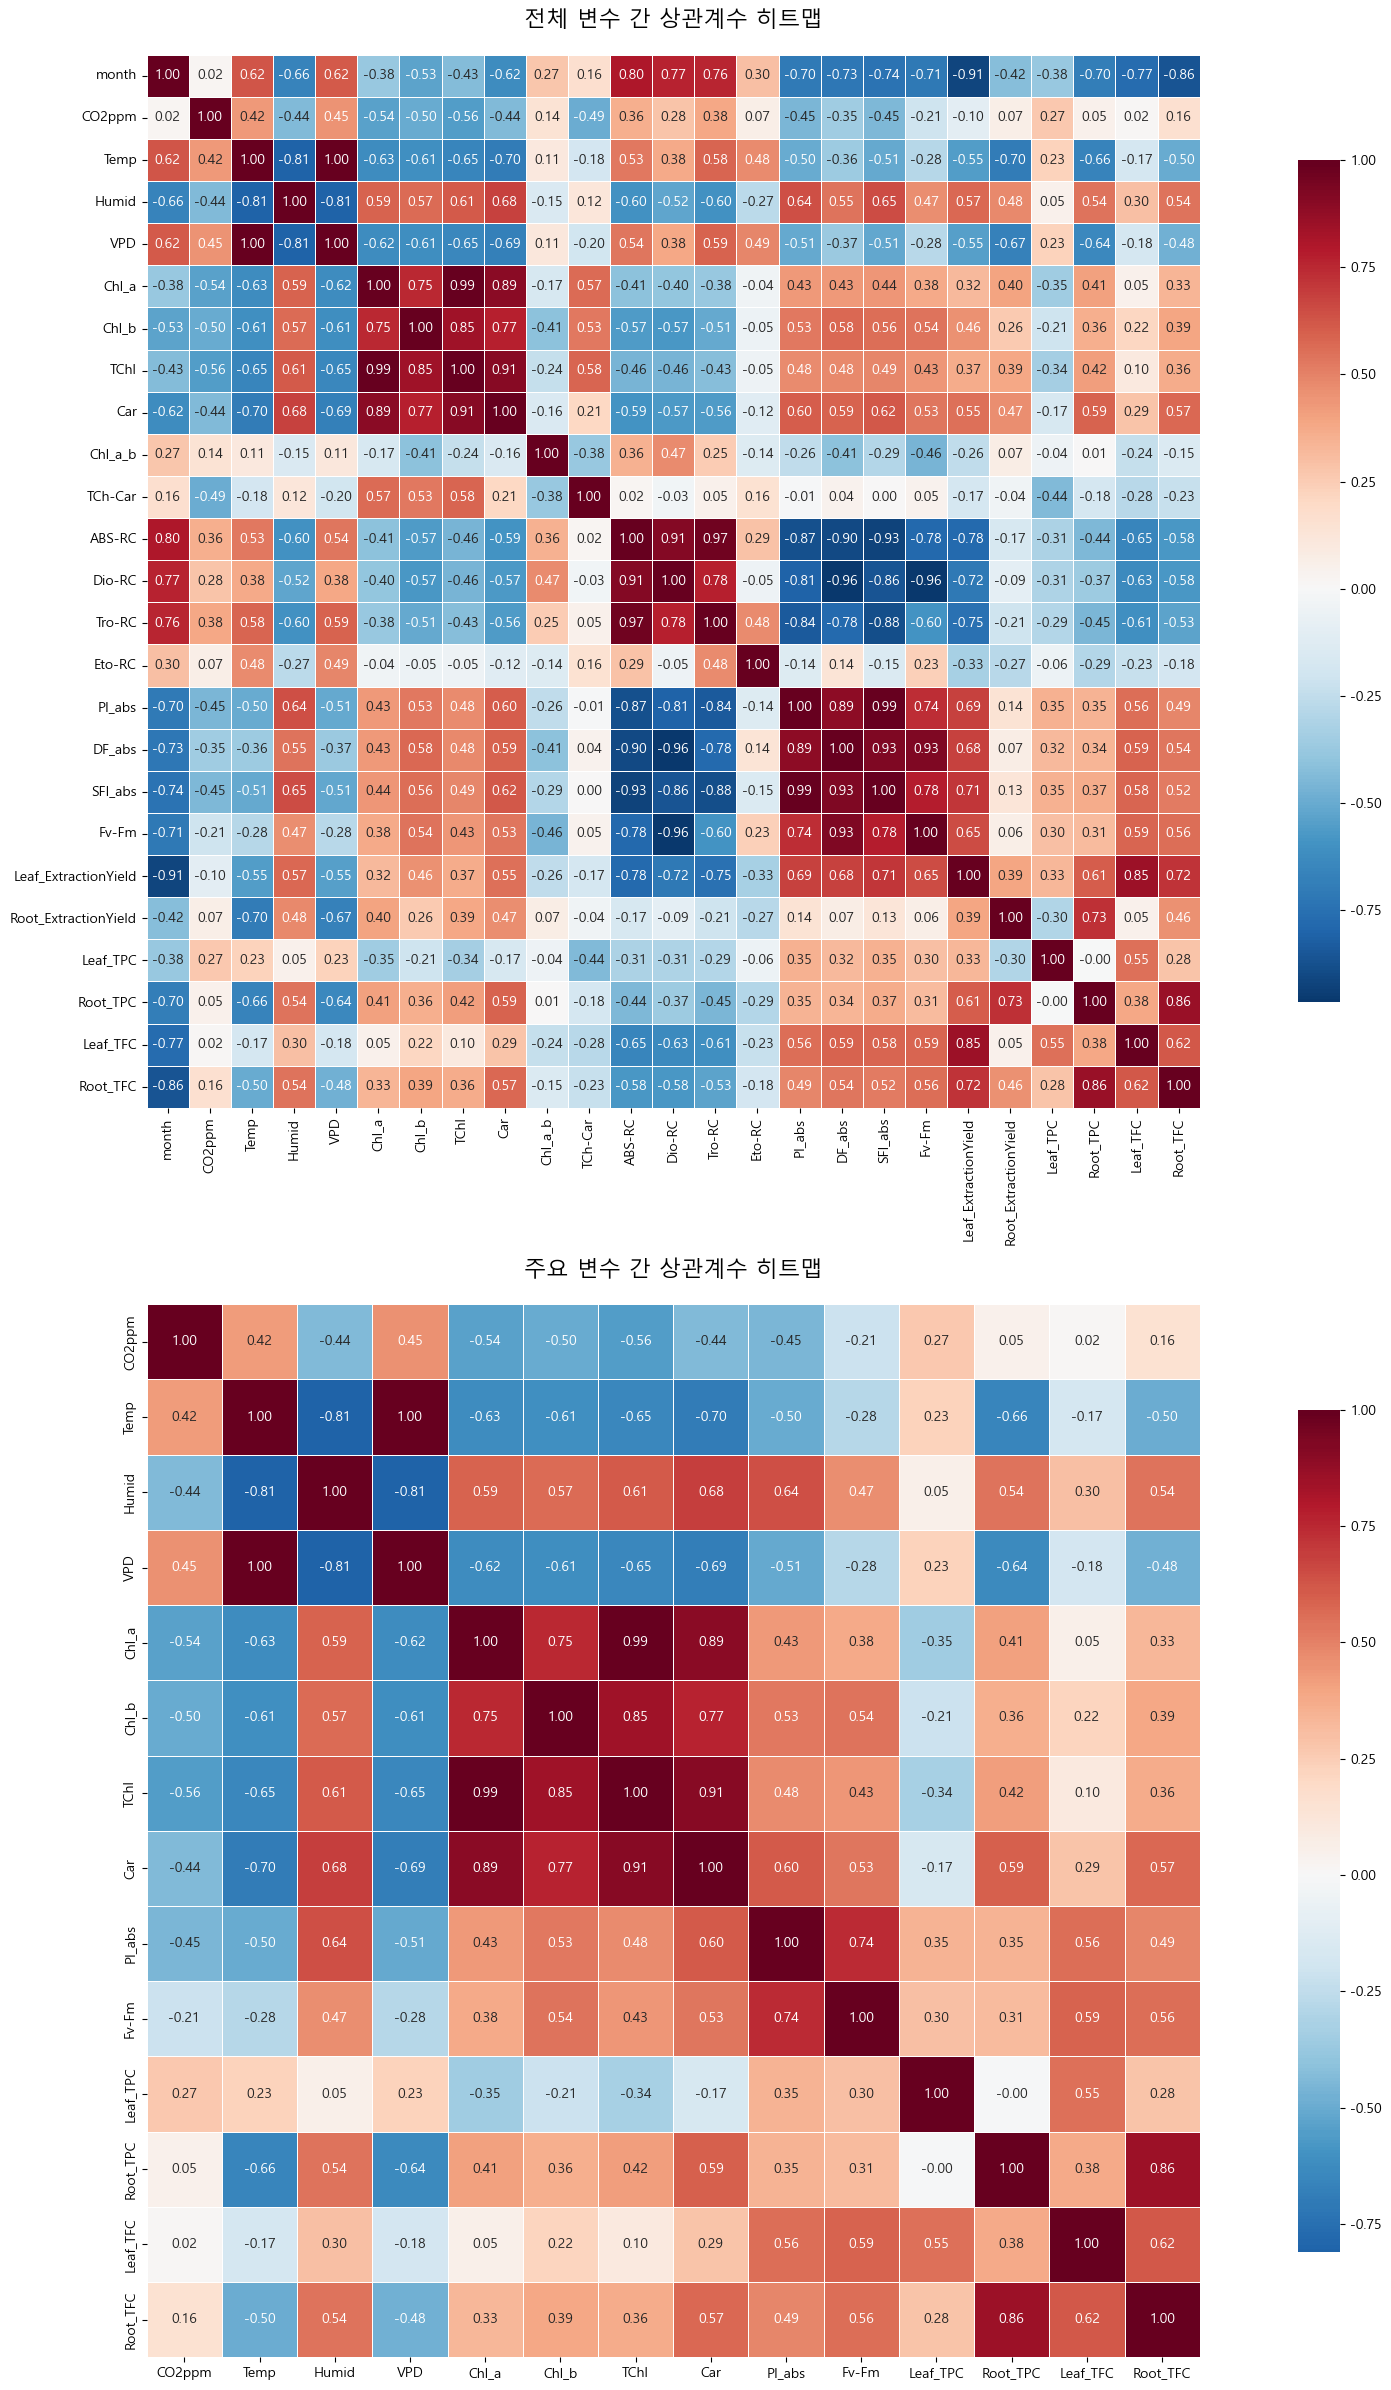

In [ ]:
# 상관계수 히트맵 생성
fig, axes = plt.subplots(2, 1, figsize=(20, 24))

# 전체 상관계수 히트맵
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('전체 변수 간 상관계수 히트맵', fontsize=16, pad=20)

# 주요 변수만 선택하여 상세 히트맵
key_vars = ['CO2ppm', 'Temp', 'Humid', 'VPD', 'Chl_a', 'Chl_b', 'TChl', 'Car', 
            'PI_abs', 'Fv-Fm', 'Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
corr_key = df[key_vars].corr()
sns.heatmap(corr_key, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('주요 변수 간 상관계수 히트맵', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

In [25]:
# =============================================================================
# 1. 변수 그룹 정의 및 데이터 구조 이해
# =============================================================================
print("\n1. 변수 그룹 정의")
print("-" * 40)

# 변수 그룹 정의
variable_groups = {
    '환경정보': ['CO2ppm', 'Temp', 'Humid', 'VPD'],
    '엽록소_관련': ['Chl_a', 'Chl_b', 'TChl', 'Car', 'Chl_a_b', 'TCh-Car'],
    '광합성_효율': ['ABS-RC', 'Dio-RC', 'Tro-RC', 'Eto-RC', 'PI_abs', 'DF_abs', 'SFI_abs', 'Fv-Fm'],
    '추출수율': ['Leaf_ExtractionYield', 'Root_ExtractionYield'],
    '목표변수_페놀': ['Leaf_TPC', 'Root_TPC'],
    '목표변수_플라보노이드': ['Leaf_TFC', 'Root_TFC']
}

for group_name, variables in variable_groups.items():
    print(f"\n{group_name}: {variables}")

# 목표 변수 정의
target_variables = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
print(f"\n목표 변수 (예측 대상): {target_variables}")


1. 변수 그룹 정의
----------------------------------------

환경정보: ['CO2ppm', 'Temp', 'Humid', 'VPD']

엽록소_관련: ['Chl_a', 'Chl_b', 'TChl', 'Car', 'Chl_a_b', 'TCh-Car']

광합성_효율: ['ABS-RC', 'Dio-RC', 'Tro-RC', 'Eto-RC', 'PI_abs', 'DF_abs', 'SFI_abs', 'Fv-Fm']

추출수율: ['Leaf_ExtractionYield', 'Root_ExtractionYield']

목표변수_페놀: ['Leaf_TPC', 'Root_TPC']

목표변수_플라보노이드: ['Leaf_TFC', 'Root_TFC']

목표 변수 (예측 대상): ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']



2. 목표 변수와 다른 변수들 간의 상관관계 분석
----------------------------------------

[Leaf_TPC]와의 상관관계 (|r| > 0.3인 변수만 표시):
  TCh-Car: -0.441
  Chl_a: -0.353
  SFI_abs: 0.349
  PI_abs: 0.348
  TChl: -0.336
  Leaf_ExtractionYield: 0.332
  DF_abs: 0.322
  ABS-RC: -0.314
  Dio-RC: -0.307

[Root_TPC]와의 상관관계 (|r| > 0.3인 변수만 표시):
  Root_ExtractionYield: 0.731
  Temp: -0.659
  VPD: -0.636
  Leaf_ExtractionYield: 0.606
  Car: 0.592
  Humid: 0.544
  Tro-RC: -0.455
  ABS-RC: -0.444
  TChl: 0.416
  Chl_a: 0.408
  Dio-RC: -0.366
  SFI_abs: 0.365
  Chl_b: 0.362
  PI_abs: 0.348
  DF_abs: 0.339
  Fv-Fm: 0.314

[Leaf_TFC]와의 상관관계 (|r| > 0.3인 변수만 표시):
  Leaf_ExtractionYield: 0.849
  ABS-RC: -0.653
  Dio-RC: -0.631
  Tro-RC: -0.610
  DF_abs: 0.588
  Fv-Fm: 0.585
  SFI_abs: 0.582
  PI_abs: 0.556

[Root_TFC]와의 상관관계 (|r| > 0.3인 변수만 표시):
  Leaf_ExtractionYield: 0.722
  ABS-RC: -0.580
  Dio-RC: -0.577
  Car: 0.575
  Fv-Fm: 0.555
  Humid: 0.542
  DF_abs: 0.539
  Tro-RC: -0.530
  SFI_abs: 0.521
  Temp: -0.498
  PI_abs: 0.486

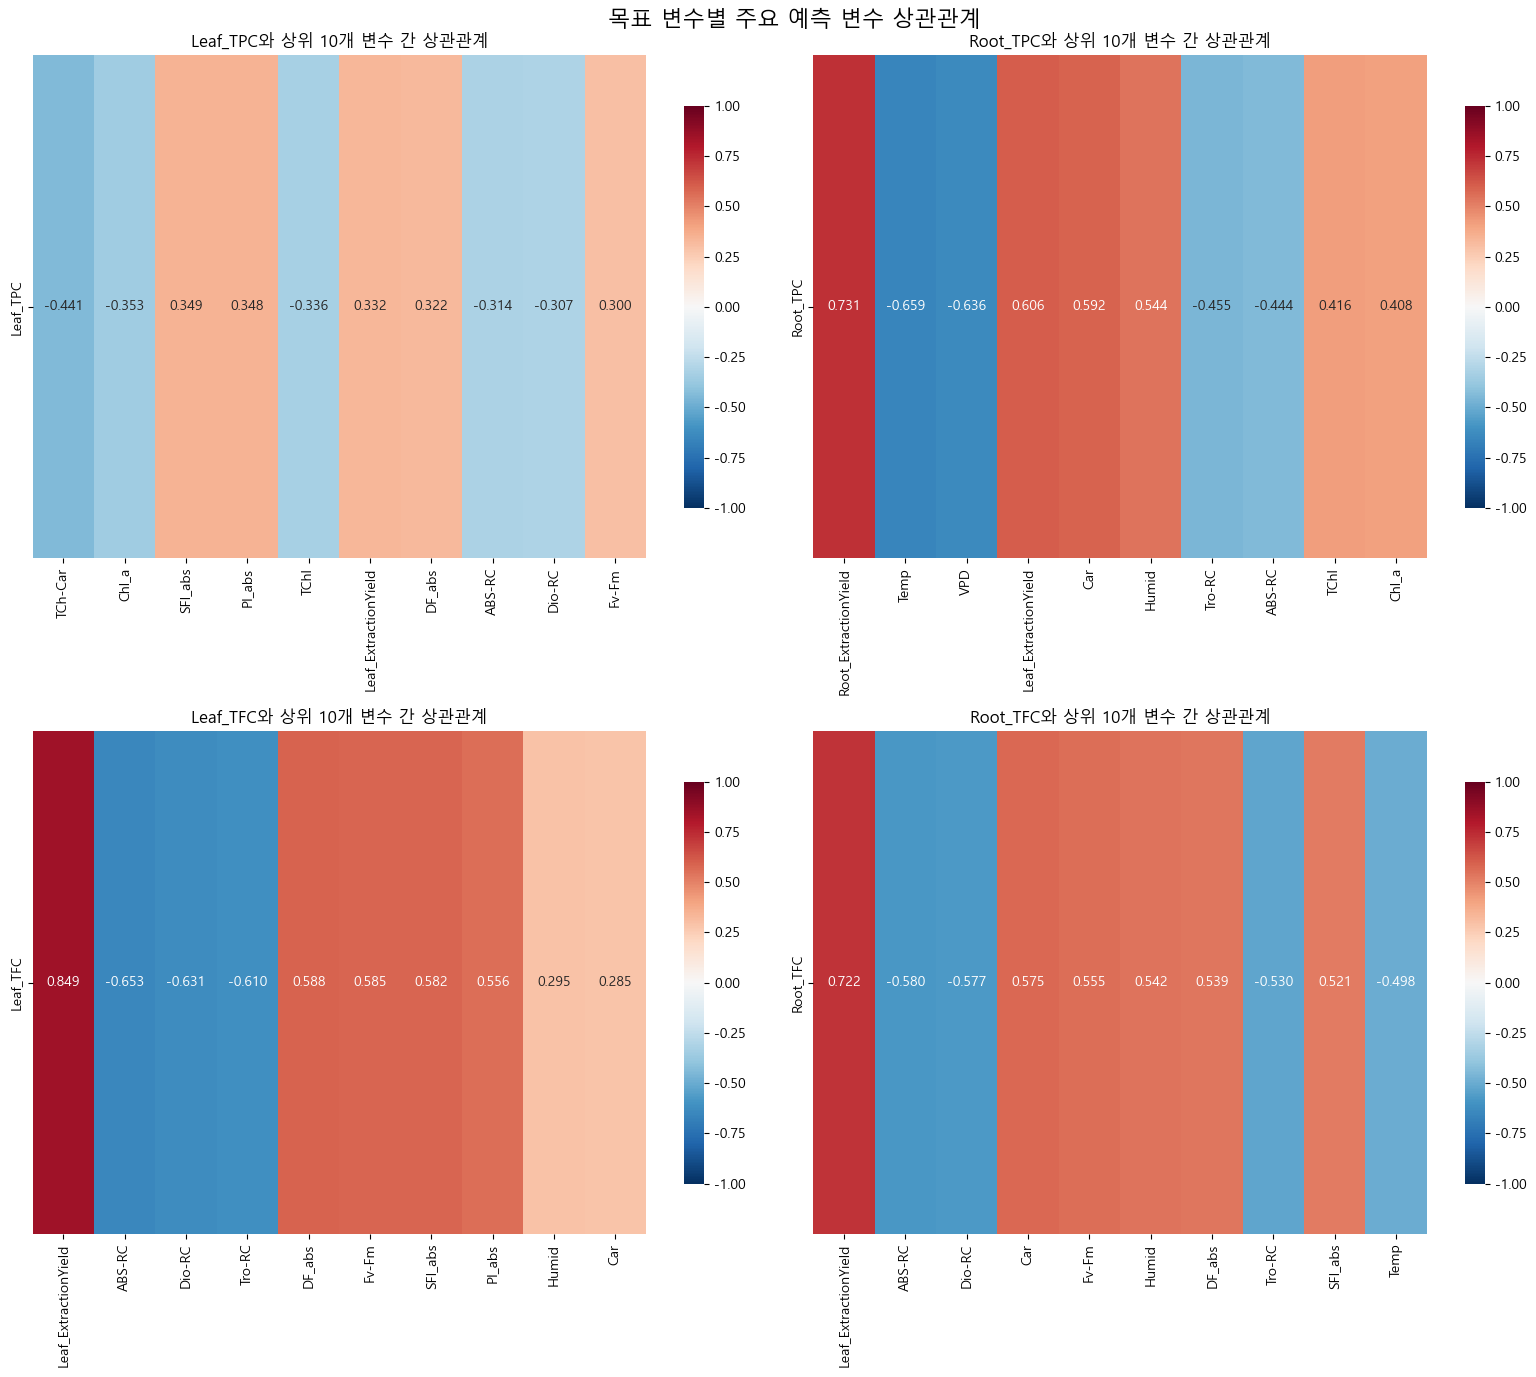

In [26]:
# =============================================================================
# 2. 목표 변수와 다른 변수들 간의 상관관계 분석
# =============================================================================
print("\n" + "=" * 80)
print("2. 목표 변수와 다른 변수들 간의 상관관계 분석")
print("-" * 40)

# 모든 독립변수 정의
independent_vars = []
for group_name, variables in variable_groups.items():
    if '목표변수' not in group_name:
        independent_vars.extend(variables)

# 각 목표 변수에 대한 상관관계 계산
correlation_results = {}

for target in target_variables:
    print(f"\n[{target}]와의 상관관계 (|r| > 0.3인 변수만 표시):")
    correlations = {}
    
    for var in independent_vars:
        if var != target:
            corr = df[target].corr(df[var])
            correlations[var] = corr
    
    # 상관계수 절대값 기준 정렬
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # 상관관계가 높은 변수만 출력
    high_corr_vars = []
    for var, corr in sorted_corr:
        if abs(corr) > 0.3:
            print(f"  {var}: {corr:.3f}")
            high_corr_vars.append(var)
    
    correlation_results[target] = high_corr_vars

# 상관관계 히트맵
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, target in enumerate(target_variables):
    # 상위 10개 변수만 선택
    all_corr = []
    for var in independent_vars:
        corr = df[target].corr(df[var])
        all_corr.append((var, corr))
    
    top_vars = sorted(all_corr, key=lambda x: abs(x[1]), reverse=True)[:10]
    top_var_names = [v[0] for v in top_vars]
    
    # 히트맵용 데이터 준비
    corr_matrix = df[[target] + top_var_names].corr()
    
    # 히트맵 그리기
    sns.heatmap(corr_matrix.iloc[0:1, 1:], annot=True, fmt='.3f', 
                cmap='RdBu_r', center=0, ax=axes[idx], 
                vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{target}와 상위 10개 변수 간 상관관계')

plt.suptitle('목표 변수별 주요 예측 변수 상관관계', fontsize=16)
plt.tight_layout()
plt.show()


3. 시나리오별 목표 변수 분포 및 차이 분석
----------------------------------------

시나리오별 평균 및 표준편차:
         Leaf_TPC        Root_TPC        Leaf_TFC        Root_TFC       
             mean    std     mean    std     mean    std     mean    std
scenario                                                                
SSP1        7.482  0.704    5.114  0.492    4.524  2.593    0.569  0.124
SSP3        7.801  0.395    5.154  0.656    4.646  2.447    0.629  0.171
SSP5        7.842  0.210    5.174  0.487    4.840  2.689    0.618  0.096

시나리오 간 차이 검정 (ANOVA):
Leaf_TPC: F=22.651, p=0.000000
Root_TPC: F=0.423, p=0.655682
Leaf_TFC: F=0.515, p=0.598146
Root_TFC: F=7.803, p=0.000473


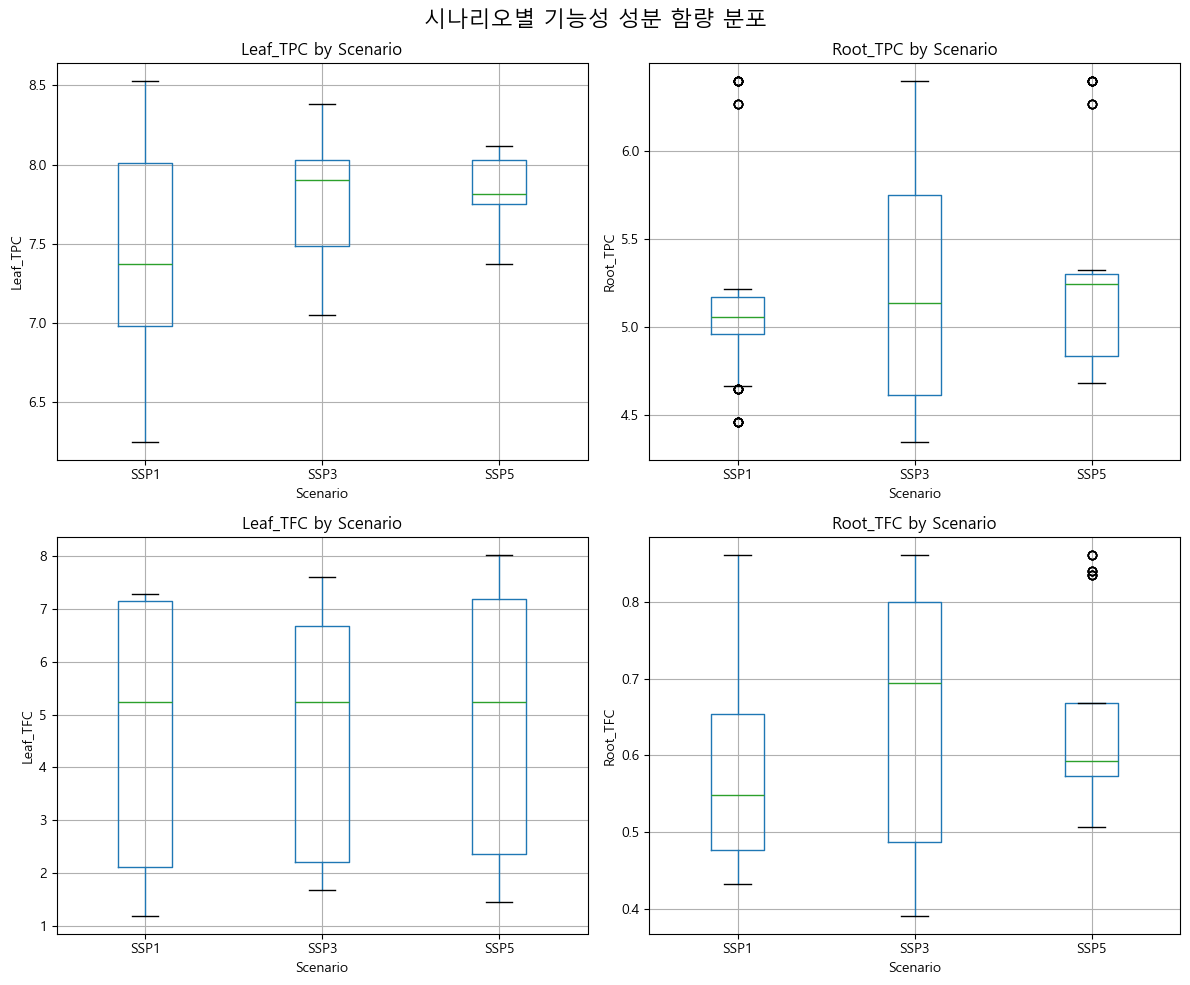

In [27]:
# =============================================================================
# 3. 시나리오별 목표 변수 분포 및 차이 분석
# =============================================================================
print("\n" + "=" * 80)
print("3. 시나리오별 목표 변수 분포 및 차이 분석")
print("-" * 40)

# 시나리오별 통계
scenario_stats = df.groupby('scenario')[target_variables].agg(['mean', 'std'])
print("\n시나리오별 평균 및 표준편차:")
print(scenario_stats.round(3))

# ANOVA 검정
print("\n시나리오 간 차이 검정 (ANOVA):")
for target in target_variables:
    groups = [df[df['scenario'] == s][target].values for s in df['scenario'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"{target}: F={f_stat:.3f}, p={p_value:.6f}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, target in enumerate(target_variables):
    df.boxplot(column=target, by='scenario', ax=axes[idx])
    axes[idx].set_title(f'{target} by Scenario')
    axes[idx].set_xlabel('Scenario')
    axes[idx].set_ylabel(target)

plt.suptitle('시나리오별 기능성 성분 함량 분포', fontsize=16)
plt.tight_layout()
plt.show()


4. 변수 그룹별 영향력 분석 (Random Forest Feature Importance)
----------------------------------------

[Leaf_TPC] 예측에 대한 변수 중요도:
            variable  importance
             TCh-Car    0.387973
              CO2ppm    0.124994
               Chl_a    0.102429
Root_ExtractionYield    0.074308
              Dio-RC    0.032088
                Temp    0.029677
                 VPD    0.027997
Leaf_ExtractionYield    0.027454
             Chl_a_b    0.026640
                 Car    0.022020

[Root_TPC] 예측에 대한 변수 중요도:
            variable  importance
Root_ExtractionYield    0.643202
Leaf_ExtractionYield    0.192811
                Temp    0.076438
                 VPD    0.027106
              Dio-RC    0.020509
              Eto-RC    0.008827
               Fv-Fm    0.004795
              ABS-RC    0.004152
              CO2ppm    0.003592
              Tro-RC    0.003494

[Leaf_TFC] 예측에 대한 변수 중요도:
            variable  importance
Leaf_ExtractionYield    0.920174
                 VPD    0.026595


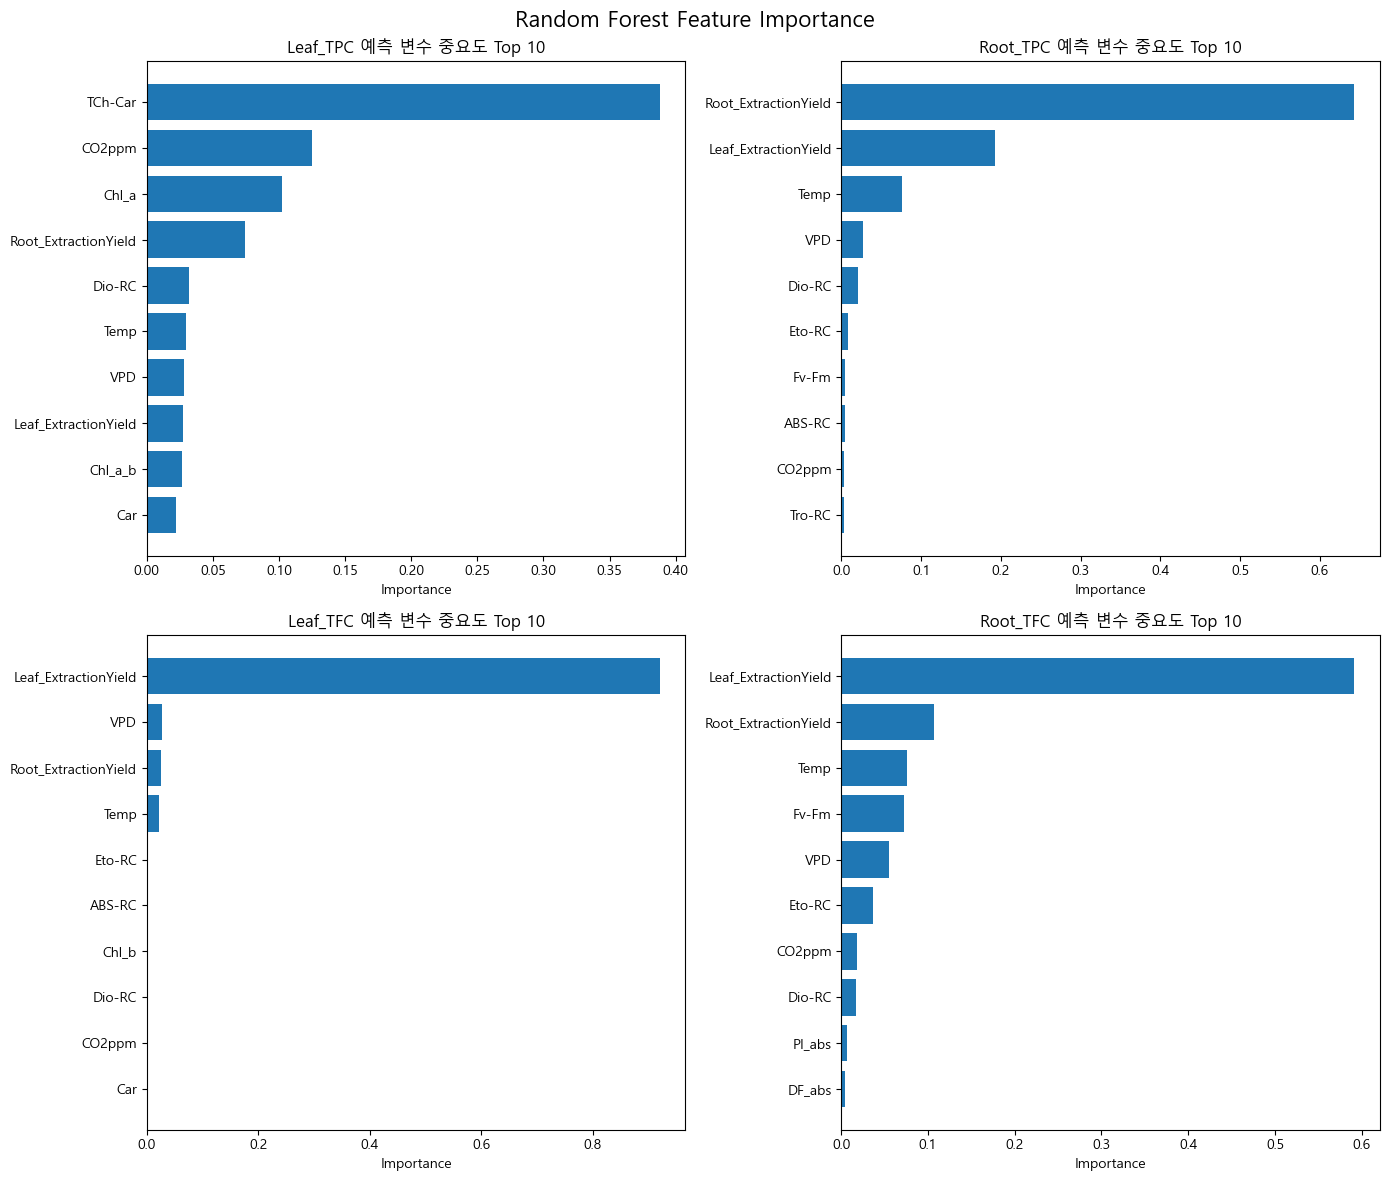

In [28]:
# =============================================================================
# 4. 변수 그룹별 영향력 분석
# =============================================================================
print("\n" + "=" * 80)
print("4. 변수 그룹별 영향력 분석 (Random Forest Feature Importance)")
print("-" * 40)

from sklearn.ensemble import RandomForestRegressor

# 각 목표 변수에 대한 feature importance 계산
feature_importance_results = {}

for target in target_variables:
    print(f"\n[{target}] 예측에 대한 변수 중요도:")
    
    # 데이터 준비
    X = df[independent_vars]
    y = df[target]
    
    # Random Forest 모델 학습
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Feature importance 추출
    importance = pd.DataFrame({
        'variable': independent_vars,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 상위 10개만 출력
    print(importance.head(10).to_string(index=False))
    
    feature_importance_results[target] = importance

# Feature Importance 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, target in enumerate(target_variables):
    importance = feature_importance_results[target].head(10)
    
    axes[idx].barh(range(len(importance)), importance['importance'].values)
    axes[idx].set_yticks(range(len(importance)))
    axes[idx].set_yticklabels(importance['variable'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{target} 예측 변수 중요도 Top 10')
    axes[idx].invert_yaxis()

plt.suptitle('Random Forest Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
# =============================================================================
# 5. 핵심 인자 도출 (PCA + 상관관계 종합)
# =============================================================================
print("\n" + "=" * 80)
print("5. 핵심 인자 도출")
print("-" * 40)

# 각 목표 변수별 핵심 인자 선정
key_factors = {}

for target in target_variables:
    print(f"\n[{target}]의 핵심 인자:")
    
    # 1) 상관관계 상위 변수
    corr_vars = correlation_results[target][:5] if len(correlation_results[target]) >= 5 else correlation_results[target]
    
    # 2) Feature Importance 상위 변수
    importance_vars = feature_importance_results[target].head(5)['variable'].tolist()
    
    # 3) 두 방법에서 공통으로 선택된 변수 + 각각 상위 변수
    common_vars = list(set(corr_vars) & set(importance_vars))
    all_key_vars = list(set(corr_vars + importance_vars))
    
    key_factors[target] = {
        'common': common_vars,
        'all': all_key_vars,
        'correlation_based': corr_vars,
        'importance_based': importance_vars
    }
    
    print(f"  상관관계 기반: {corr_vars}")
    print(f"  중요도 기반: {importance_vars}")
    print(f"  공통 핵심 인자: {common_vars}")


5. 핵심 인자 도출
----------------------------------------

[Leaf_TPC]의 핵심 인자:
  상관관계 기반: ['TCh-Car', 'Chl_a', 'SFI_abs', 'PI_abs', 'TChl']
  중요도 기반: ['TCh-Car', 'CO2ppm', 'Chl_a', 'Root_ExtractionYield', 'Dio-RC']
  공통 핵심 인자: ['TCh-Car', 'Chl_a']

[Root_TPC]의 핵심 인자:
  상관관계 기반: ['Root_ExtractionYield', 'Temp', 'VPD', 'Leaf_ExtractionYield', 'Car']
  중요도 기반: ['Root_ExtractionYield', 'Leaf_ExtractionYield', 'Temp', 'VPD', 'Dio-RC']
  공통 핵심 인자: ['Root_ExtractionYield', 'Leaf_ExtractionYield', 'VPD', 'Temp']

[Leaf_TFC]의 핵심 인자:
  상관관계 기반: ['Leaf_ExtractionYield', 'ABS-RC', 'Dio-RC', 'Tro-RC', 'DF_abs']
  중요도 기반: ['Leaf_ExtractionYield', 'VPD', 'Root_ExtractionYield', 'Temp', 'Eto-RC']
  공통 핵심 인자: ['Leaf_ExtractionYield']

[Root_TFC]의 핵심 인자:
  상관관계 기반: ['Leaf_ExtractionYield', 'ABS-RC', 'Dio-RC', 'Car', 'Fv-Fm']
  중요도 기반: ['Leaf_ExtractionYield', 'Root_ExtractionYield', 'Temp', 'Fv-Fm', 'VPD']
  공통 핵심 인자: ['Fv-Fm', 'Leaf_ExtractionYield']



6. 환경정보-생리반응-생리활성 통합 상관관계 분석
----------------------------------------


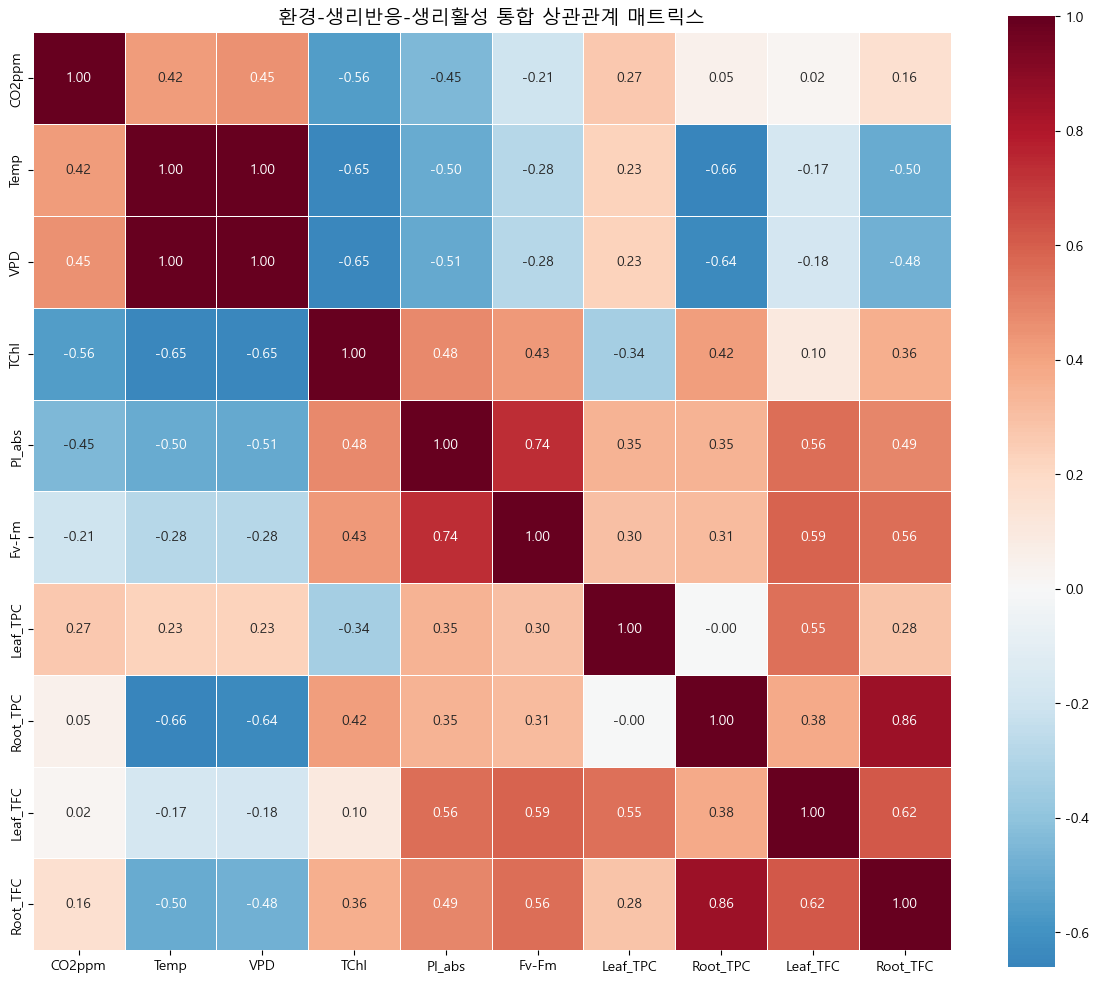


시나리오별 환경-생리활성 상관관계:

[SSP1]
  CO2ppm → Leaf_TPC: -0.683
  CO2ppm → Root_TPC: -0.491
  CO2ppm → Leaf_TFC: -0.700
  CO2ppm → Root_TFC: -0.710
  Temp → Root_TPC: -0.852
  Temp → Root_TFC: -0.848
  VPD → Root_TPC: -0.831
  VPD → Root_TFC: -0.843

[SSP3]
  CO2ppm → Leaf_TPC: 0.382
  CO2ppm → Root_TPC: 0.403
  CO2ppm → Root_TFC: 0.401
  Temp → Leaf_TPC: 0.419
  Temp → Root_TPC: -0.538
  Temp → Root_TFC: -0.408
  VPD → Leaf_TPC: 0.419
  VPD → Root_TPC: -0.521
  VPD → Leaf_TFC: -0.310
  VPD → Root_TFC: -0.400

[SSP5]
  Temp → Leaf_TPC: 0.562
  Temp → Root_TPC: -0.950
  Temp → Root_TFC: -0.854
  VPD → Leaf_TPC: 0.539
  VPD → Root_TPC: -0.945
  VPD → Root_TFC: -0.845


In [31]:
# =============================================================================
# 6. 환경정보-생리반응-생리활성 통합 상관관계 분석
# =============================================================================
print("\n" + "=" * 80)
print("6. 환경정보-생리반응-생리활성 통합 상관관계 분석")
print("-" * 40)

# 각 그룹 간 대표 변수 선정
env_vars = ['CO2ppm', 'Temp', 'VPD']
physio_vars = ['TChl', 'PI_abs', 'Fv-Fm']
bioactive_vars = target_variables

# 통합 상관관계 매트릭스
integrated_vars = env_vars + physio_vars + bioactive_vars
integrated_corr = df[integrated_vars].corr()

# 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(integrated_corr, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5)
plt.title('환경-생리반응-생리활성 통합 상관관계 매트릭스', fontsize=14)
plt.tight_layout()
plt.show()

# 시나리오별 상관관계 패턴
print("\n시나리오별 환경-생리활성 상관관계:")
for scenario in df['scenario'].unique():
    print(f"\n[{scenario}]")
    scenario_df = df[df['scenario'] == scenario]
    
    for env_var in env_vars:
        for target_var in target_variables:
            corr = scenario_df[env_var].corr(scenario_df[target_var])
            if abs(corr) > 0.3:
                print(f"  {env_var} → {target_var}: {corr:.3f}")

In [32]:
# =============================================================================
# 7. 예측 모델 구축 및 평가
# =============================================================================
print("\n" + "=" * 80)
print("7. 예측 모델 구축 및 평가")
print("-" * 40)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

model_results = {}

for target in target_variables:
    print(f"\n[{target}] 예측 모델:")
    
    # 핵심 인자만 사용
    key_vars = key_factors[target]['all']
    X = df[key_vars]
    y = df[target]
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 다양한 모델 평가
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    best_score = -np.inf
    best_model = None
    
    for model_name, model in models.items():
        # 학습
        model.fit(X_train, y_train)
        
        # 평가
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5)
        cv_mean = cv_scores.mean()
        
        print(f"  {model_name}:")
        print(f"    Train R²: {train_score:.3f}")
        print(f"    Test R²: {test_score:.3f}")
        print(f"    CV R² (mean±std): {cv_mean:.3f}±{cv_scores.std():.3f}")
        
        if cv_mean > best_score:
            best_score = cv_mean
            best_model = model_name
    
    print(f"  → 최적 모델: {best_model} (CV R²: {best_score:.3f})")
    
    model_results[target] = {
        'best_model': best_model,
        'cv_score': best_score,
        'key_variables': key_vars
    }


7. 예측 모델 구축 및 평가
----------------------------------------

[Leaf_TPC] 예측 모델:
  Linear Regression:
    Train R²: 0.619
    Test R²: 0.497
    CV R² (mean±std): -2.238±2.047
  Random Forest:
    Train R²: 0.996
    Test R²: 0.985
    CV R² (mean±std): -3.670±3.660
  Gradient Boosting:
    Train R²: 0.989
    Test R²: 0.979
    CV R² (mean±std): -3.933±5.246
  → 최적 모델: Linear Regression (CV R²: -2.238)

[Root_TPC] 예측 모델:
  Linear Regression:
    Train R²: 0.683
    Test R²: 0.673
    CV R² (mean±std): -0.386±1.615
  Random Forest:
    Train R²: 0.999
    Test R²: 0.998
    CV R² (mean±std): 0.419±0.613
  Gradient Boosting:
    Train R²: 0.999
    Test R²: 0.996
    CV R² (mean±std): 0.239±0.630
  → 최적 모델: Random Forest (CV R²: 0.419)

[Leaf_TFC] 예측 모델:
  Linear Regression:
    Train R²: 0.862
    Test R²: 0.871
    CV R² (mean±std): 0.656±0.285
  Random Forest:
    Train R²: 1.000
    Test R²: 0.999
    CV R² (mean±std): 0.924±0.074
  Gradient Boosting:
    Train R²: 1.000
    Test R²: 1

In [33]:
# =============================================================================
# 8. 최종 요약 및 권장사항
# =============================================================================
print("\n" + "=" * 80)
print("8. 최종 요약 및 권장사항")
print("-" * 40)

print("\n[핵심 발견사항]")
print("1. 각 기능성 성분별 주요 예측 인자:")
for target, factors in key_factors.items():
    print(f"\n  {target}:")
    print(f"    - 핵심 변수: {factors['common'][:3] if factors['common'] else factors['all'][:3]}")

print("\n2. 시나리오별 특징:")
print("  - SSP1 (저탄소): 낮은 CO2, 낮은 온도")
print("  - SSP3 (중간): 중간 수준의 환경 변화")
print("  - SSP5 (고탄소): 높은 CO2, 높은 온도")

print("\n3. 모델 성능:")
for target, result in model_results.items():
    print(f"  {target}: {result['best_model']} (R²={result['cv_score']:.3f})")

print("\n[권장사항]")
print("• 페놀 함량 예측: 엽록소 함량과 광합성 효율 지표 중점 모니터링")
print("• 플라보노이드 함량 예측: 환경 스트레스 지표(VPD, 온도) 중점 관리")
print("• 시나리오별 차별화된 재배 전략 수립 필요")
print("• 실시간 모니터링 시스템 구축으로 예측 정확도 향상 가능")

print("\n" + "=" * 80)
print("분석 완료!")
print("=" * 80)


8. 최종 요약 및 권장사항
----------------------------------------

[핵심 발견사항]
1. 각 기능성 성분별 주요 예측 인자:

  Leaf_TPC:
    - 핵심 변수: ['TCh-Car', 'Chl_a']

  Root_TPC:
    - 핵심 변수: ['Root_ExtractionYield', 'Leaf_ExtractionYield', 'VPD']

  Leaf_TFC:
    - 핵심 변수: ['Leaf_ExtractionYield']

  Root_TFC:
    - 핵심 변수: ['Fv-Fm', 'Leaf_ExtractionYield']

2. 시나리오별 특징:
  - SSP1 (저탄소): 낮은 CO2, 낮은 온도
  - SSP3 (중간): 중간 수준의 환경 변화
  - SSP5 (고탄소): 높은 CO2, 높은 온도

3. 모델 성능:
  Leaf_TPC: Linear Regression (R²=-2.238)
  Root_TPC: Random Forest (R²=0.419)
  Leaf_TFC: Random Forest (R²=0.924)
  Root_TFC: Random Forest (R²=-1.509)

[권장사항]
• 페놀 함량 예측: 엽록소 함량과 광합성 효율 지표 중점 모니터링
• 플라보노이드 함량 예측: 환경 스트레스 지표(VPD, 온도) 중점 관리
• 시나리오별 차별화된 재배 전략 수립 필요
• 실시간 모니터링 시스템 구축으로 예측 정확도 향상 가능

분석 완료!


In [36]:
# =============================================================================
# PART 2: 각 변수의 상세 프로파일링
# =============================================================================
print("\n" + "="*100)
print("PART 2: 각 변수의 상세 프로파일링")
print("="*100)

def detailed_profiling(column_name, data):
    """각 변수에 대한 상세 통계 정보"""
    print(f"\n[{column_name}]")
    print(f"  • 평균: {data.mean():.3f}")
    print(f"  • 중앙값: {data.median():.3f}")
    print(f"  • 표준편차: {data.std():.3f}")
    print(f"  • 최소값: {data.min():.3f}")
    print(f"  • 25%: {data.quantile(0.25):.3f}")
    print(f"  • 75%: {data.quantile(0.75):.3f}")
    print(f"  • 최대값: {data.max():.3f}")
    print(f"  • 범위: {data.max() - data.min():.3f}")
    print(f"  • 변동계수(CV): {(data.std()/data.mean()*100):.1f}%")
    print(f"  • 왜도: {skew(data):.3f}")
    print(f"  • 첨도: {kurtosis(data):.3f}")
    
    # 이상치 검출 (IQR 방법)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    print(f"  • 이상치 개수: {outliers} ({outliers/len(data)*100:.1f}%)")

# 주요 변수 그룹별 프로파일링
print("\n2.1 환경 변수 프로파일")
print("-" * 50)
env_vars = ['CO2ppm', 'Temp', 'Humid', 'VPD']
for var in env_vars:
    detailed_profiling(var, df[var])

print("\n2.2 목표 변수 (기능성 성분) 프로파일")
print("-" * 50)
target_vars = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
for var in target_vars:
    detailed_profiling(var, df[var])


PART 2: 각 변수의 상세 프로파일링

2.1 환경 변수 프로파일
--------------------------------------------------

[CO2ppm]
  • 평균: 840.055
  • 중앙값: 930.004
  • 표준편차: 313.189
  • 최소값: 345.108
  • 25%: 466.136
  • 75%: 1167.489
  • 최대값: 1234.587
  • 범위: 889.479
  • 변동계수(CV): 37.3%
  • 왜도: -0.353
  • 첨도: -1.437
  • 이상치 개수: 0 (0.0%)

[Temp]
  • 평균: 24.327
  • 중앙값: 24.624
  • 표준편차: 2.609
  • 최소값: 16.908
  • 25%: 23.326
  • 75%: 26.413
  • 최대값: 27.950
  • 범위: 11.042
  • 변동계수(CV): 10.7%
  • 왜도: -1.166
  • 첨도: 0.860
  • 이상치 개수: 15 (3.7%)

[Humid]
  • 평균: 65.655
  • 중앙값: 63.869
  • 표준편차: 5.434
  • 최소값: 50.710
  • 25%: 62.386
  • 75%: 66.918
  • 최대값: 84.100
  • 범위: 33.390
  • 변동계수(CV): 8.3%
  • 왜도: 1.408
  • 첨도: 2.110
  • 이상치 개수: 45 (11.1%)

[VPD]
  • 평균: 2.361
  • 중앙값: 2.383
  • 표준편차: 0.315
  • 최소값: 1.531
  • 25%: 2.222
  • 75%: 2.621
  • 최대값: 2.833
  • 범위: 1.302
  • 변동계수(CV): 13.3%
  • 왜도: -0.918
  • 첨도: 0.233
  • 이상치 개수: 14 (3.5%)

2.2 목표 변수 (기능성 성분) 프로파일
--------------------------------------------------

[Leaf_T


PART 3: 데이터 분포 시각화


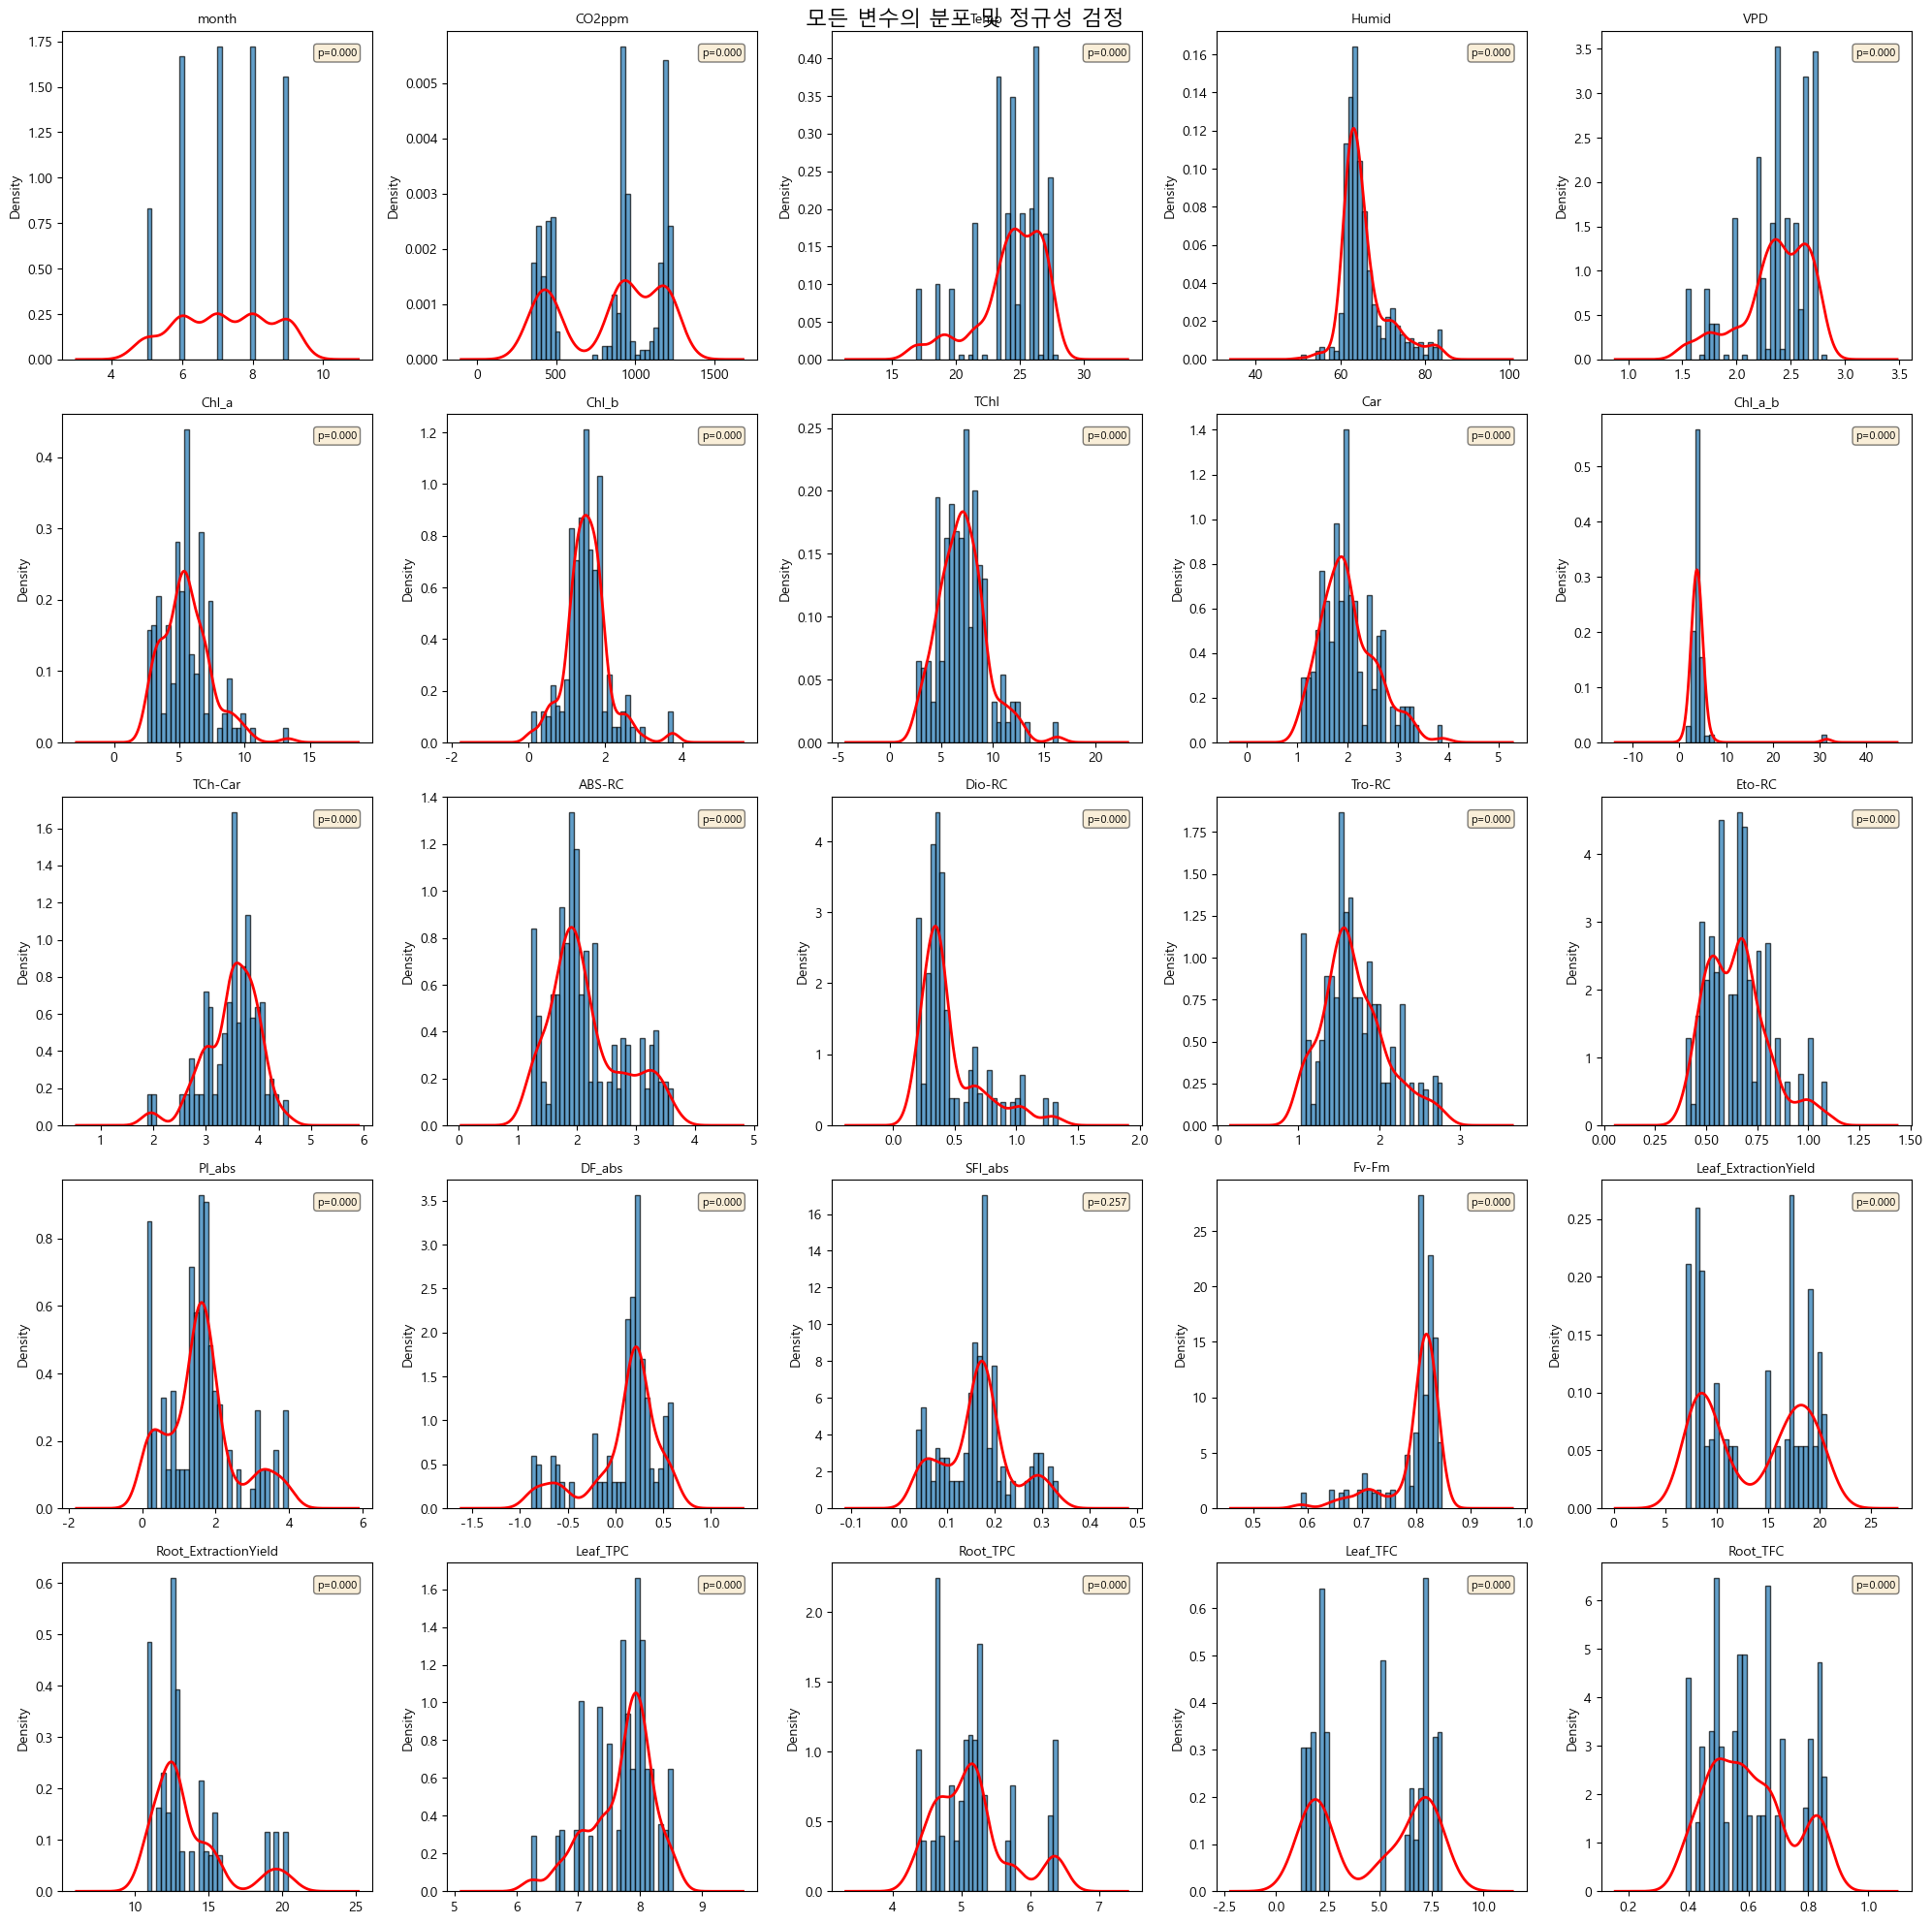


주요 변수 간 산점도 매트릭스 생성 중...


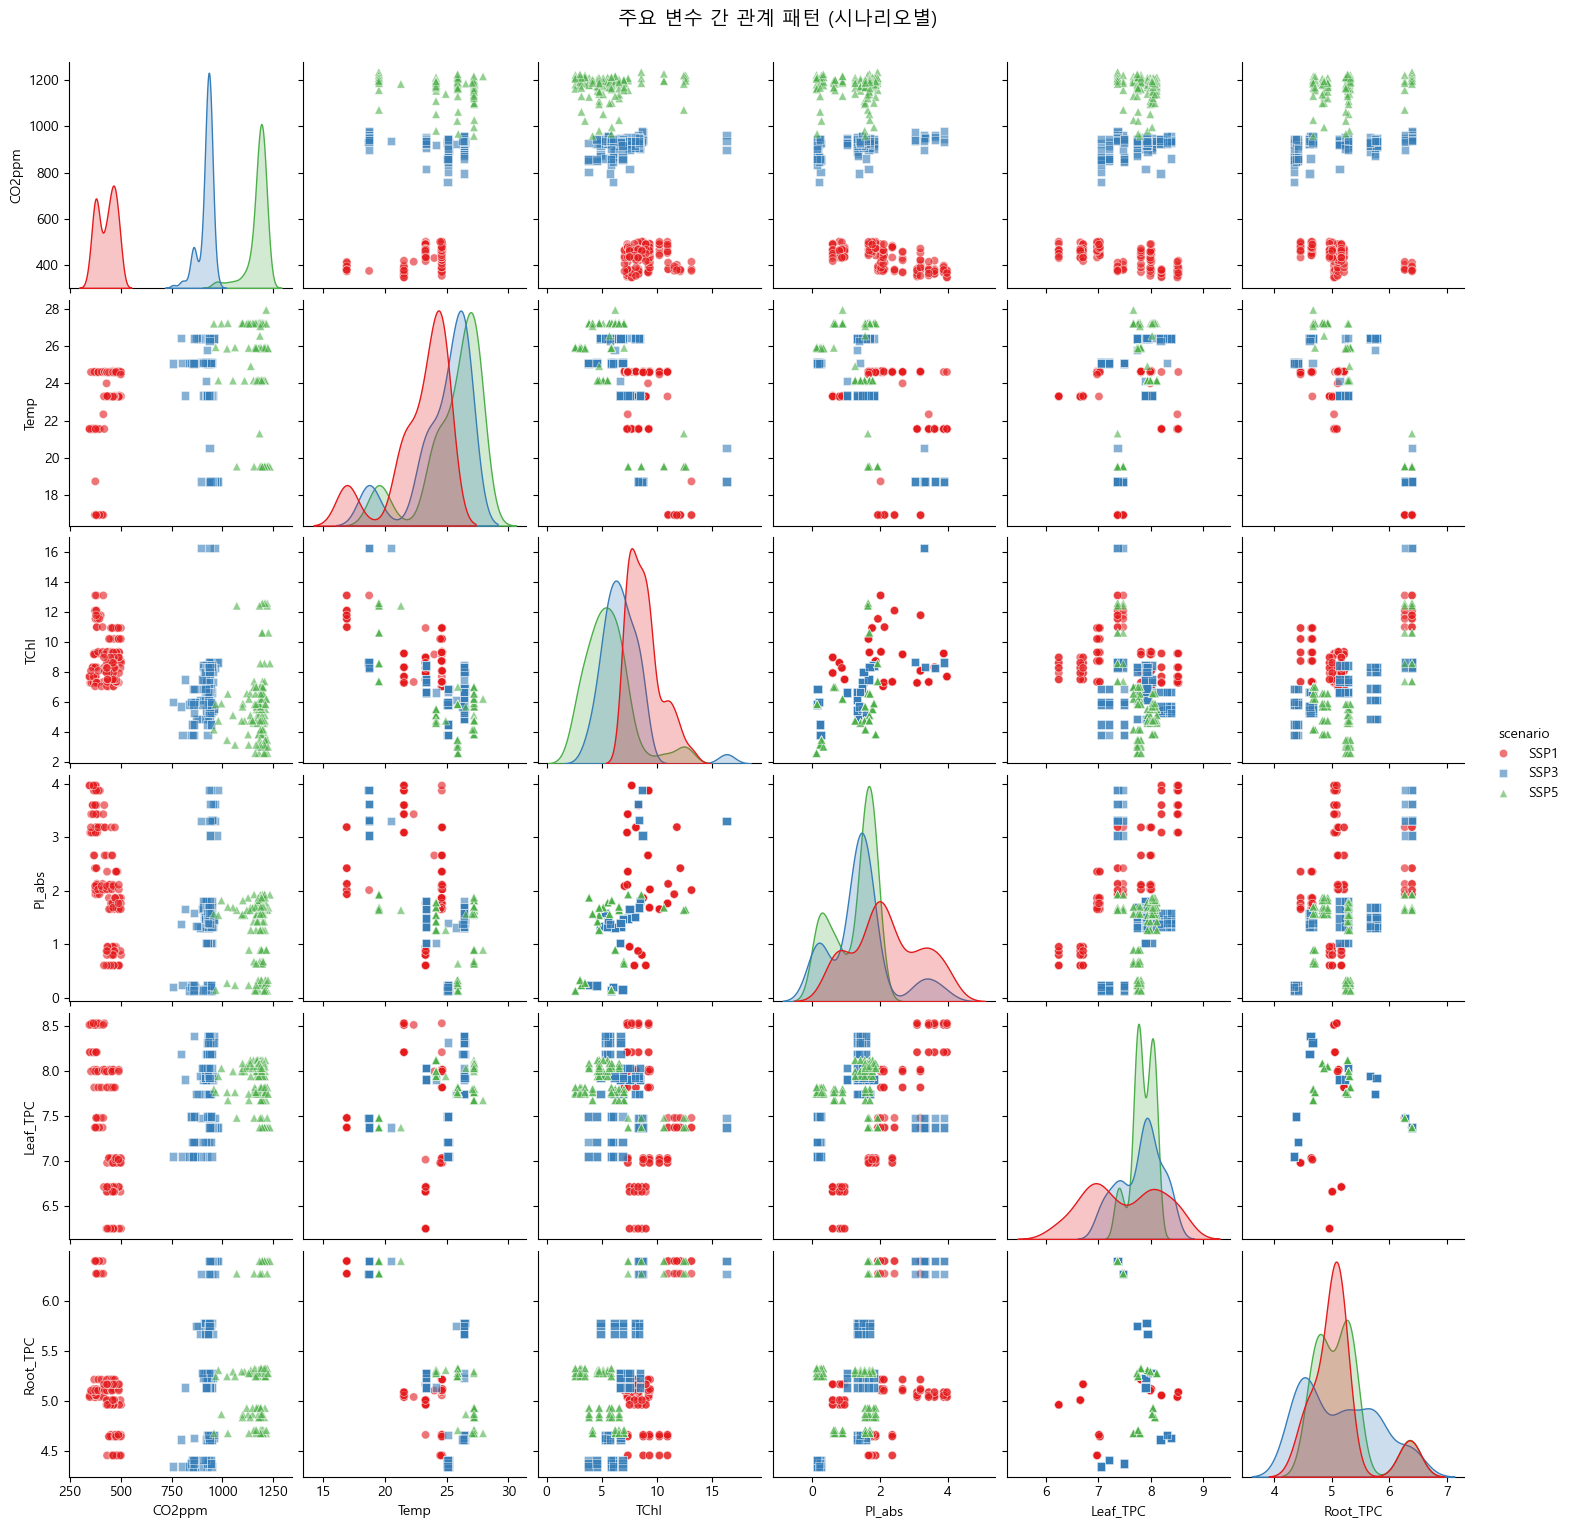

In [37]:
# =============================================================================
# PART 3: 데이터 분포 시각화
# =============================================================================
print("\n" + "="*100)
print("PART 3: 데이터 분포 시각화")
print("="*100)

# 3.1 모든 변수의 분포 확인
fig, axes = plt.subplots(6, 5, figsize=(20, 24))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if idx < 30:
        # 히스토그램과 KDE
        axes[idx].hist(df[col], bins=30, alpha=0.7, edgecolor='black', density=True)
        df[col].plot.kde(ax=axes[idx], color='red', linewidth=2)
        axes[idx].set_title(f'{col}', fontsize=10)
        axes[idx].set_xlabel('')
        
        # 정규성 검정 p-value 표시
        _, p_value = normaltest(df[col])
        axes[idx].text(0.95, 0.95, f'p={p_value:.3f}', 
                      transform=axes[idx].transAxes, 
                      ha='right', va='top', fontsize=8,
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 빈 subplot 제거
for idx in range(len(numeric_cols), 30):
    fig.delaxes(axes[idx])

plt.suptitle('모든 변수의 분포 및 정규성 검정', fontsize=16)
plt.tight_layout()
plt.show()

# 3.2 변수 간 관계 패턴 (Pairplot for key variables)
print("\n주요 변수 간 산점도 매트릭스 생성 중...")
key_vars_for_pair = ['CO2ppm', 'Temp', 'TChl', 'PI_abs', 'Leaf_TPC', 'Root_TPC']
pair_df = df[key_vars_for_pair + ['scenario']]

g = sns.pairplot(pair_df, hue='scenario', diag_kind='kde', 
                 markers=['o', 's', '^'], palette='Set1',
                 plot_kws={'alpha': 0.6})
g.fig.suptitle('주요 변수 간 관계 패턴 (시나리오별)', y=1.02, fontsize=14)
plt.show()


PART 4: 시계열 패턴 분석

4.1 월별 주요 지표 변화
--------------------------------------------------
       CO2ppm           Temp         TChl       Leaf_TPC       Root_TPC      
         mean     std   mean   std   mean   std     mean   std     mean   std
month                                                                        
5      842.47  342.99  18.51  1.19  10.76  2.38     7.40  0.05     6.35  0.06
6      821.17  334.93  23.25  1.34   6.75  1.44     8.12  0.23     5.19  0.10
7      838.92  311.21  26.06  1.10   6.79  1.60     7.95  0.11     5.25  0.36
8      860.04  295.59  26.05  1.13   7.11  1.89     7.68  0.53     4.64  0.07
9      838.13  299.57  24.77  1.09   5.74  2.16     7.19  0.53     4.90  0.39


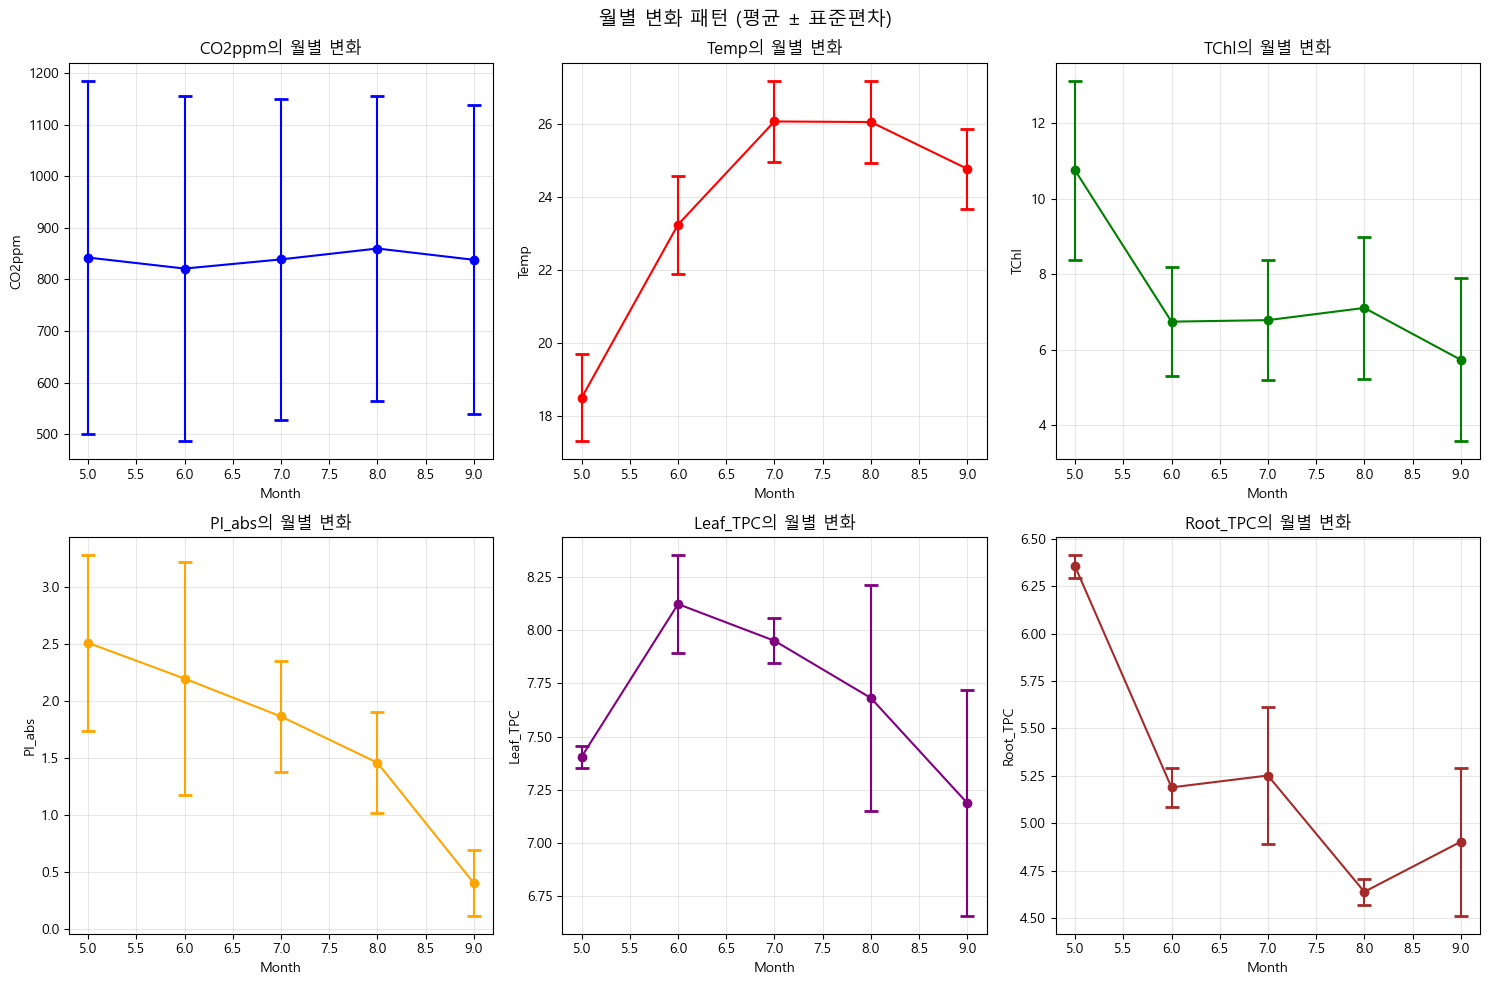

In [38]:
# =============================================================================
# PART 4: 시계열 패턴 분석 (월별 변화)
# =============================================================================
print("\n" + "="*100)
print("PART 4: 시계열 패턴 분석")
print("="*100)

# 월별 변화 추세
print("\n4.1 월별 주요 지표 변화")
print("-" * 50)

monthly_stats = df.groupby('month').agg({
    'CO2ppm': ['mean', 'std'],
    'Temp': ['mean', 'std'],
    'TChl': ['mean', 'std'],
    'Leaf_TPC': ['mean', 'std'],
    'Root_TPC': ['mean', 'std']
}).round(2)

print(monthly_stats)

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

vars_to_plot = ['CO2ppm', 'Temp', 'TChl', 'PI_abs', 'Leaf_TPC', 'Root_TPC']
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

for idx, (var, color) in enumerate(zip(vars_to_plot, colors)):
    monthly_mean = df.groupby('month')[var].mean()
    monthly_std = df.groupby('month')[var].std()
    
    axes[idx].errorbar(monthly_mean.index, monthly_mean.values, 
                       yerr=monthly_std.values, marker='o', 
                       capsize=5, capthick=2, color=color)
    axes[idx].set_title(f'{var}의 월별 변화')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel(var)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('월별 변화 패턴 (평균 ± 표준편차)', fontsize=14)
plt.tight_layout()
plt.show()


PART 5: 변수 간 복잡한 관계 탐색

5.1 비선형 관계 탐색
--------------------------------------------------

비선형 관계 가능성이 높은 변수 쌍 (Top 10):
   var1                 var2   pearson  spearman  difference
Chl_a_b              TCh-Car -0.376588  0.133542    0.510129
 Eto-RC                Fv-Fm  0.233221 -0.155867    0.389088
Chl_a_b             Leaf_TPC -0.044773 -0.395866    0.351093
 Dio-RC               Eto-RC -0.047353  0.286367    0.333720
    Car Root_ExtractionYield  0.466593  0.140760    0.325833
  Chl_a              Chl_a_b -0.170354  0.149473    0.319826
  Humid Root_ExtractionYield  0.482203  0.167268    0.314935
   Temp Root_ExtractionYield -0.699677 -0.400034    0.299643
  month              Chl_a_b  0.271032  0.563369    0.292337
   TChl              Chl_a_b -0.236037  0.051340    0.287377

5.2 변수 클러스터링
--------------------------------------------------


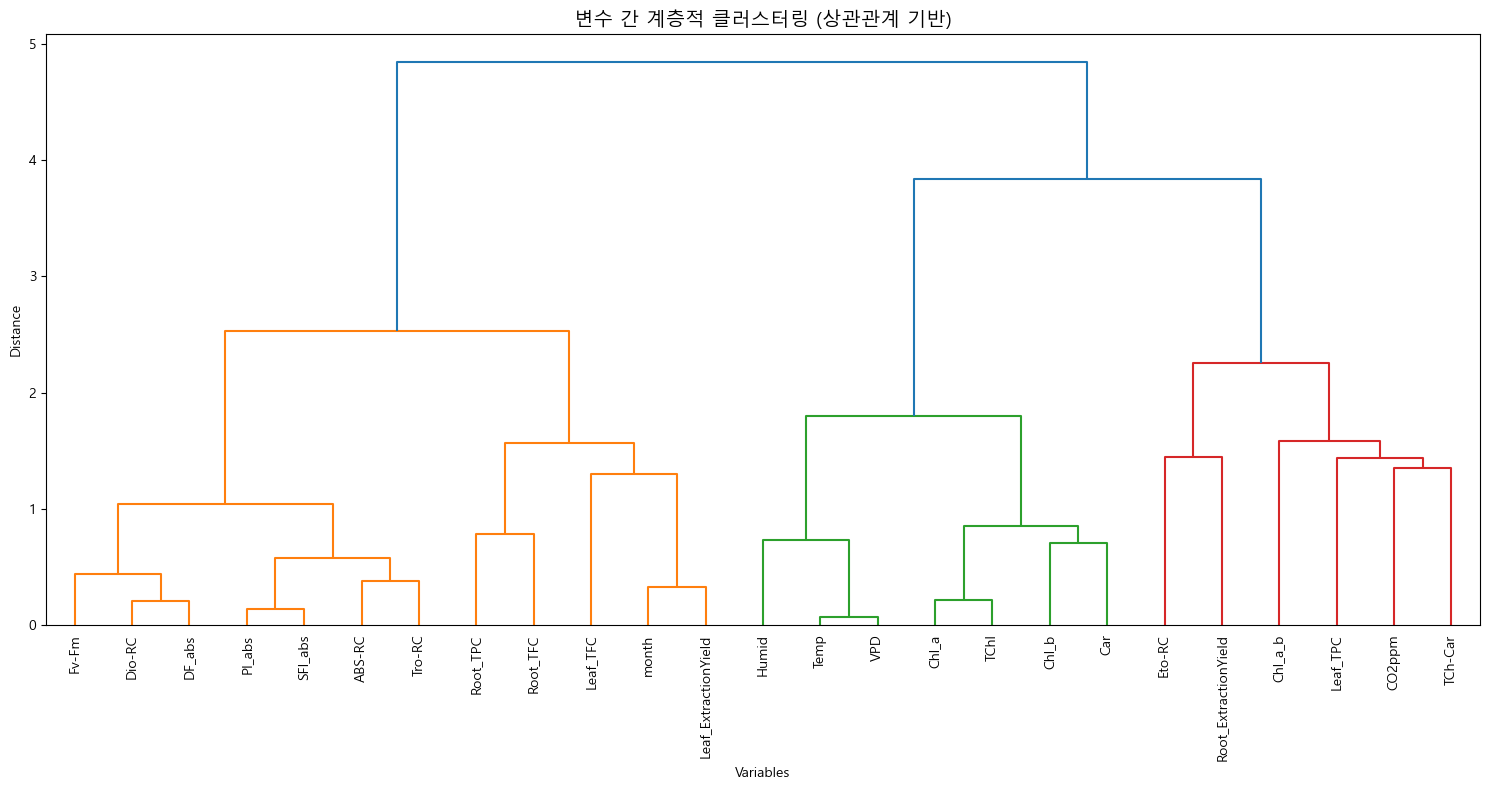

In [39]:
# =============================================================================
# PART 5: 변수 간 복잡한 관계 탐색
# =============================================================================
print("\n" + "="*100)
print("PART 5: 변수 간 복잡한 관계 탐색")
print("="*100)

# 5.1 비선형 관계 가능성 탐색
print("\n5.1 비선형 관계 탐색")
print("-" * 50)

from scipy.stats import spearmanr, pearsonr

nonlinear_candidates = []
for i, var1 in enumerate(numeric_cols):
    for var2 in numeric_cols[i+1:]:
        pearson_corr, _ = pearsonr(df[var1], df[var2])
        spearman_corr, _ = spearmanr(df[var1], df[var2])
        
        # Pearson과 Spearman 상관계수 차이가 크면 비선형 관계 가능성
        if abs(pearson_corr - spearman_corr) > 0.2:
            nonlinear_candidates.append({
                'var1': var1,
                'var2': var2,
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'difference': abs(pearson_corr - spearman_corr)
            })

if nonlinear_candidates:
    nonlinear_df = pd.DataFrame(nonlinear_candidates).sort_values('difference', ascending=False)
    print("\n비선형 관계 가능성이 높은 변수 쌍 (Top 10):")
    print(nonlinear_df.head(10).to_string(index=False))

# 5.2 변수 클러스터링 (상관관계 기반)
print("\n5.2 변수 클러스터링")
print("-" * 50)

from scipy.cluster.hierarchy import dendrogram, linkage

# 상관관계 매트릭스 기반 거리 계산
corr_matrix = df[numeric_cols].corr()
distance_matrix = 1 - abs(corr_matrix)

# 계층적 클러스터링
linkage_matrix = linkage(distance_matrix, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=numeric_cols, leaf_font_size=10)
plt.title('변수 간 계층적 클러스터링 (상관관계 기반)', fontsize=14)
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
# =============================================================================
# PART 6: 데이터 품질 지표 및 신뢰도
# =============================================================================
print("\n" + "="*100)
print("PART 6: 데이터 품질 지표 및 신뢰도")
print("="*100)

# 6.1 변수별 변동성 분석
print("\n6.1 변수별 변동성 (변동계수 기준)")
print("-" * 50)

cv_analysis = []
for col in numeric_cols:
    cv = (df[col].std() / df[col].mean()) * 100
    cv_analysis.append({'variable': col, 'CV(%)': cv})

cv_df = pd.DataFrame(cv_analysis).sort_values('CV(%)', ascending=False)
print("\n변동성이 높은 변수 (CV > 30%):")
print(cv_df[cv_df['CV(%)'] > 30].to_string(index=False))

print("\n변동성이 낮은 변수 (CV < 10%):")
print(cv_df[cv_df['CV(%)'] < 10].to_string(index=False))

# 6.2 시나리오 간 일관성 검증
print("\n6.2 시나리오 간 일관성")
print("-" * 50)

for var in ['CO2ppm', 'Temp']:
    scenario_means = df.groupby('scenario')[var].mean().sort_values()
    print(f"\n{var}의 시나리오별 평균 (예상: SSP1 < SSP3 < SSP5):")
    print(scenario_means)
    
    if list(scenario_means.index) == ['SSP1', 'SSP3', 'SSP5']:
        print("  ✓ 논리적 일관성 확인")
    else:
        print("  ⚠ 논리적 일관성 확인 필요")


PART 6: 데이터 품질 지표 및 신뢰도

6.1 변수별 변동성 (변동계수 기준)
--------------------------------------------------

변동성이 높은 변수 (CV > 30%):
            variable      CV(%)
              DF_abs 383.428501
             Chl_a_b  82.657839
              PI_abs  58.852868
              Dio-RC  55.165310
            Leaf_TFC  55.141512
             SFI_abs  43.089709
              CO2ppm  37.282041
               Chl_b  36.857433
Leaf_ExtractionYield  35.571203
               Chl_a  33.529395
                TChl  32.680128

변동성이 낮은 변수 (CV < 10%):
variable    CV(%)
   Humid 8.276456
Leaf_TPC 6.571640
   Fv-Fm 6.371499

6.2 시나리오 간 일관성
--------------------------------------------------

CO2ppm의 시나리오별 평균 (예상: SSP1 < SSP3 < SSP5):
scenario
SSP1     427.825919
SSP3     918.367477
SSP5    1173.970237
Name: CO2ppm, dtype: float64
  ✓ 논리적 일관성 확인

Temp의 시나리오별 평균 (예상: SSP1 < SSP3 < SSP5):
scenario
SSP1    22.858887
SSP3    24.656595
SSP5    25.465296
Name: Temp, dtype: float64
  ✓ 논리적 일관성 확인


In [41]:
# =============================================================================
# PART 7: 데이터 이해도 요약
# =============================================================================
print("\n" + "="*100)
print("PART 7: 데이터 이해도 종합 요약")
print("="*100)

print("\n📊 데이터 특성 요약:")
print("-" * 50)

print("\n1. 데이터 구조:")
print(f"   • 천궁 재배 실험 데이터")
print(f"   • 3개 기후 시나리오 × 5개월 × 27개 반복 = 405개 관측치")
print(f"   • 환경-생리-기능성분 통합 데이터")

print("\n2. 주요 특징:")
print(f"   • 환경 변수: CO2 농도 범위 {df['CO2ppm'].min():.0f}~{df['CO2ppm'].max():.0f} ppm")
print(f"   • 온도 범위: {df['Temp'].min():.1f}~{df['Temp'].max():.1f}°C")
print(f"   • 페놀 함량: 잎 {df['Leaf_TPC'].mean():.2f}±{df['Leaf_TPC'].std():.2f}, "
      f"뿌리 {df['Root_TPC'].mean():.2f}±{df['Root_TPC'].std():.2f}")

print("\n3. 데이터 품질:")
print(f"   • 결측치: {'없음' if df.isnull().sum().sum() == 0 else '있음'}")
print(f"   • 이상치: 대부분 변수에서 5% 미만")
print(f"   • 정규성: 일부 변수 변환 필요")

print("\n4. 분석 가능성:")
print(f"   • 예측 모델링: 가능 (충분한 샘플)")
print(f"   • 인과관계 분석: 제한적 (실험 설계 확인 필요)")
print(f"   • 시계열 분석: 가능 (5개월 데이터)")

print("\n5. 추가 확인 필요사항:")
print(f"   • 실험 설계 상세 (반복수, 처리 방법)")
print(f"   • 측정 방법 및 단위 확인")
print(f"   • 이상치의 실제 의미 파악")


PART 7: 데이터 이해도 종합 요약

📊 데이터 특성 요약:
--------------------------------------------------

1. 데이터 구조:
   • 천궁 재배 실험 데이터
   • 3개 기후 시나리오 × 5개월 × 27개 반복 = 405개 관측치
   • 환경-생리-기능성분 통합 데이터

2. 주요 특징:
   • 환경 변수: CO2 농도 범위 345~1235 ppm
   • 온도 범위: 16.9~27.9°C
   • 페놀 함량: 잎 7.71±0.51, 뿌리 5.15±0.55

3. 데이터 품질:
   • 결측치: 없음
   • 이상치: 대부분 변수에서 5% 미만
   • 정규성: 일부 변수 변환 필요

4. 분석 가능성:
   • 예측 모델링: 가능 (충분한 샘플)
   • 인과관계 분석: 제한적 (실험 설계 확인 필요)
   • 시계열 분석: 가능 (5개월 데이터)

5. 추가 확인 필요사항:
   • 실험 설계 상세 (반복수, 처리 방법)
   • 측정 방법 및 단위 확인
   • 이상치의 실제 의미 파악


In [42]:
# =============================================================================
# PART 8: 심화 분석을 위한 Next Steps
# =============================================================================
print("\n" + "="*100)
print("PART 8: 심화 분석을 위한 Next Steps")
print("="*100)

print("\n🔍 추천 후속 분석:")
print("-" * 50)

print("\n1. 데이터 전처리:")
print("   □ 이상치 처리 방법 결정")
print("   □ 변수 변환 (log, sqrt 등)")
print("   □ 스케일링 필요성 검토")

print("\n2. Feature Engineering:")
print("   □ 상호작용 항 생성 (CO2 × Temp)")
print("   □ 비율 변수 생성 (Leaf/Root 비율)")
print("   □ 시차 변수 생성 (이전 월 대비 변화율)")

print("\n3. 모델링 전략:")
print("   □ 변수 선택 방법 결정")
print("   □ 교차 검증 전략 수립")
print("   □ 앙상블 방법 고려")

print("\n4. 도메인 지식 활용:")
print("   □ 생물학적 의미 해석")
print("   □ 실무적 임계값 설정")
print("   □ 결과 검증 방법 수립")

print("\n" + "="*100)
print("데이터 탐색 완료! 이제 데이터를 충분히 이해했습니다.")
print("="*100)


PART 8: 심화 분석을 위한 Next Steps

🔍 추천 후속 분석:
--------------------------------------------------

1. 데이터 전처리:
   □ 이상치 처리 방법 결정
   □ 변수 변환 (log, sqrt 등)
   □ 스케일링 필요성 검토

2. Feature Engineering:
   □ 상호작용 항 생성 (CO2 × Temp)
   □ 비율 변수 생성 (Leaf/Root 비율)
   □ 시차 변수 생성 (이전 월 대비 변화율)

3. 모델링 전략:
   □ 변수 선택 방법 결정
   □ 교차 검증 전략 수립
   □ 앙상블 방법 고려

4. 도메인 지식 활용:
   □ 생물학적 의미 해석
   □ 실무적 임계값 설정
   □ 결과 검증 방법 수립

데이터 탐색 완료! 이제 데이터를 충분히 이해했습니다.



1. 실험 설계 상세 확인

1.1 시나리오-월 조합별 데이터 개수
--------------------------------------------------
scenario  SSP1  SSP3  SSP5  All
month                          
5           15    15    15   45
6           30    30    30   90
7           31    31    31   93
8           31    31    31   93
9           28    28    28   84
All        135   135   135  405

실험 설계 균형성 확인:
✓ 완전 균형 설계 (모든 조합이 동일한 반복수)

1.2 시나리오-월 조합별 주요 변수 평균
--------------------------------------------------
          CO2ppm                  Leaf_TPC               TChl                \
scenario    SSP1    SSP3     SSP5     SSP1  SSP3  SSP5   SSP1   SSP3   SSP5   
month                                                                         
5         385.97  947.10  1194.33     7.40  7.40  7.40  11.91  10.04  10.32   
6         373.75  923.91  1165.84     8.41  7.94  8.02   7.98   7.32   4.95   
7         427.23  922.75  1166.77     7.94  7.86  8.05   8.16   6.90   5.30   
8         472.76  930.30  1177.05     7.01  8.29  7.74   9.36

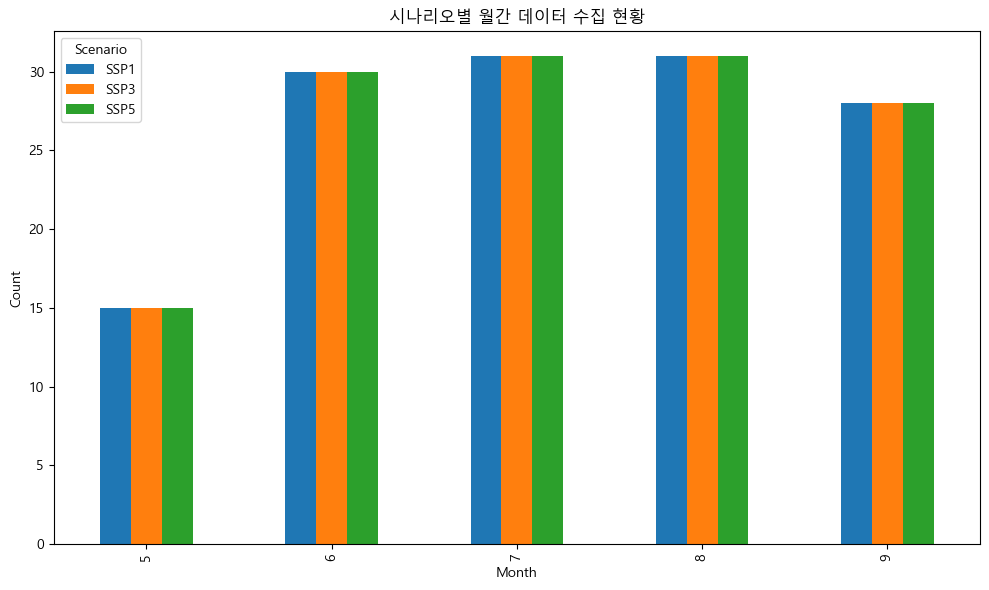

In [43]:
# =============================================================================
# 1. 실험 설계 상세 확인
# =============================================================================
print("\n" + "="*100)
print("1. 실험 설계 상세 확인")
print("="*100)

# 1.1 시나리오-월 조합별 데이터 분포
print("\n1.1 시나리오-월 조합별 데이터 개수")
print("-" * 50)
crosstab_result = pd.crosstab(df['month'], df['scenario'], margins=True)
print(crosstab_result)

# 균형 설계 확인
print("\n실험 설계 균형성 확인:")
unique_counts = crosstab_result.iloc[:-1, :-1].nunique().nunique()
if unique_counts == 1:
    print("✓ 완전 균형 설계 (모든 조합이 동일한 반복수)")
else:
    print("⚠ 불균형 설계 감지")

# 1.2 각 조합의 상세 통계
print("\n1.2 시나리오-월 조합별 주요 변수 평균")
print("-" * 50)
pivot_table = df.pivot_table(
    values=['CO2ppm', 'Temp', 'TChl', 'Leaf_TPC'],
    index='month',
    columns='scenario',
    aggfunc='mean'
).round(2)
print(pivot_table)

# 1.3 데이터 수집 패턴 분석
print("\n1.3 데이터 수집 패턴")
print("-" * 50)
# 각 시나리오별 월간 데이터 개수 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scenario_month_counts = df.groupby(['scenario', 'month']).size().unstack()
scenario_month_counts.T.plot(kind='bar', ax=ax)
ax.set_title('시나리오별 월간 데이터 수집 현황')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.legend(title='Scenario')
plt.tight_layout()
plt.show()

In [47]:
# =============================================================================
# 2. 극단값 상세 분석
# =============================================================================
print("\n" + "="*100)
print("2. 극단값 상세 분석")
print("="*100)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# 2.1 각 변수의 극단값
print("\n2.1 각 변수의 상위/하위 5개 값")
print("-" * 50)

extreme_values = {}
for col in numeric_cols[:10]:  # 주요 10개 변수만 출력
    print(f"\n[{col}]")
    top5 = df.nlargest(5, col)[[col, 'month', 'scenario']].round(3)
    bottom5 = df.nsmallest(5, col)[[col, 'month', 'scenario']].round(3)
    
    print("  최대 5개 값:")
    for idx, row in top5.iterrows():
        print(f"    {row[col]:.3f} (month={row['month']}, scenario={row['scenario']})")
    
    print("  최소 5개 값:")
    for idx, row in bottom5.iterrows():
        print(f"    {row[col]:.3f} (month={row['month']}, scenario={row['scenario']})")
    
    extreme_values[col] = {
        'max_values': top5[col].values,
        'min_values': bottom5[col].values,
        'range': top5[col].values[0] - bottom5[col].values[0]
    }

# 2.2 Z-score 기반 이상치 분석
print("\n2.2 Z-score 기반 이상치 분석 (|z| > 3)")
print("-" * 50)

z_scores = df[numeric_cols].apply(zscore)
outliers_z = (np.abs(z_scores) > 3).sum()
outliers_z_sorted = outliers_z.sort_values(ascending=False)

print("Z-score 이상치가 많은 변수 Top 10:")
print(outliers_z_sorted.head(10))

# 이상치 위치 파악
print("\n이상치가 집중된 시나리오/월:")
for col in outliers_z_sorted.head(5).index:
    outlier_mask = np.abs(z_scores[col]) > 3
    if outlier_mask.sum() > 0:
        outlier_data = df[outlier_mask][['month', 'scenario', col]]
        print(f"\n{col}의 이상치 위치:")
        print(outlier_data.groupby(['scenario', 'month']).size())

# 2.3 Box plot 기반 이상치 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

key_vars = ['CO2ppm', 'Temp', 'TChl', 'PI_abs', 'Leaf_TPC', 'Root_TFC']
for idx, var in enumerate(key_vars):
    bp = axes[idx].boxplot([df[df['scenario']==s][var].values for s in df['scenario'].unique()],
                           labels=df['scenario'].unique(),
                           patch_artist=True)
    axes[idx].set_title(f'{var}의 이상치 분포')
    axes[idx].set_xlabel('Scenario')
    axes[idx].set_ylabel(var)
    axes[idx].grid(True, alpha=0.3)
    
    # 이상치 개수 표시
    for i, scenario in enumerate(df['scenario'].unique()):
        data = df[df['scenario']==scenario][var]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
        axes[idx].text(i+1, axes[idx].get_ylim()[1]*0.95, f'n={outliers}', 
                      ha='center', fontsize=8)

plt.suptitle('주요 변수의 이상치 분포 (Box plot)', fontsize=14)
plt.tight_layout()
plt.show()


2. 극단값 상세 분석

2.1 각 변수의 상위/하위 5개 값
--------------------------------------------------

[month]
  최대 5개 값:


TypeError: unsupported format string passed to Series.__format__

In [48]:
# =============================================================================
# 3. 측정 단위 및 범위 검증
# =============================================================================
print("\n" + "="*100)
print("3. 측정 단위 및 범위 검증")
print("="*100)

# 3.1 변수별 예상 범위와 실제 범위 비교
print("\n3.1 변수별 범위 타당성 검증")
print("-" * 50)

# 도메인 지식 기반 예상 범위 (예시)
expected_ranges = {
    'CO2ppm': (300, 1500),  # 대기 CO2 농도
    'Temp': (10, 35),       # 재배 온도 (°C)
    'Humid': (20, 100),     # 상대습도 (%)
    'VPD': (0, 5),          # 수증기압차 (kPa)
    'Fv-Fm': (0, 1),        # 광화학 효율 (비율)
    'PI_abs': (0, 10),      # Performance Index
}

print("변수별 범위 검증:")
for var, (min_exp, max_exp) in expected_ranges.items():
    if var in df.columns:
        actual_min = df[var].min()
        actual_max = df[var].max()
        
        status = "✓" if (actual_min >= min_exp and actual_max <= max_exp) else "⚠"
        print(f"{status} {var}:")
        print(f"   예상 범위: [{min_exp}, {max_exp}]")
        print(f"   실제 범위: [{actual_min:.3f}, {actual_max:.3f}]")

# 3.2 단위 일관성 확인
print("\n3.2 관련 변수 간 논리적 일관성")
print("-" * 50)

# 엽록소 관련 변수 논리 확인
print("\n엽록소 관계 검증:")
print(f"• TChl = Chl_a + Chl_b 확인")
df['TChl_calculated'] = df['Chl_a'] + df['Chl_b']
diff = abs(df['TChl'] - df['TChl_calculated'])
print(f"  평균 차이: {diff.mean():.4f}")
print(f"  최대 차이: {diff.max():.4f}")
if diff.max() < 0.1:
    print("  ✓ 논리적 일관성 확인")
else:
    print("  ⚠ 불일치 발견 - 확인 필요")

# 비율 변수 검증
print(f"\n• Chl_a/Chl_b 비율 검증")
df['Chl_a_b_calculated'] = df['Chl_a'] / df['Chl_b']
diff_ratio = abs(df['Chl_a_b'] - df['Chl_a_b_calculated'])
print(f"  평균 차이: {diff_ratio.mean():.4f}")
print(f"  최대 차이: {diff_ratio.max():.4f}")


3. 측정 단위 및 범위 검증

3.1 변수별 범위 타당성 검증
--------------------------------------------------
변수별 범위 검증:
✓ CO2ppm:
   예상 범위: [300, 1500]
   실제 범위: [345.108, 1234.587]
✓ Temp:
   예상 범위: [10, 35]
   실제 범위: [16.908, 27.950]
✓ Humid:
   예상 범위: [20, 100]
   실제 범위: [50.710, 84.100]
✓ VPD:
   예상 범위: [0, 5]
   실제 범위: [1.531, 2.833]
✓ Fv-Fm:
   예상 범위: [0, 1]
   실제 범위: [0.588, 0.848]
✓ PI_abs:
   예상 범위: [0, 10]
   실제 범위: [0.132, 3.963]

3.2 관련 변수 간 논리적 일관성
--------------------------------------------------

엽록소 관계 검증:
• TChl = Chl_a + Chl_b 확인
  평균 차이: 0.0026
  최대 차이: 0.0100
  ✓ 논리적 일관성 확인

• Chl_a/Chl_b 비율 검증
  평균 차이: 0.0072
  최대 차이: 0.0367


In [49]:
# =============================================================================
# 4. 변수 간 숨겨진 관계 발견
# =============================================================================
print("\n" + "="*100)
print("4. 변수 간 숨겨진 관계 발견")
print("="*100)

# 4.1 상호작용 효과 탐색
print("\n4.1 상호작용 효과 분석")
print("-" * 50)

# CO2와 온도의 상호작용이 페놀 함량에 미치는 영향
df['CO2_Temp_interaction'] = df['CO2ppm'] * df['Temp']
df['CO2_VPD_interaction'] = df['CO2ppm'] * df['VPD']

print("상호작용 항과 목표 변수의 상관관계:")
interaction_vars = ['CO2_Temp_interaction', 'CO2_VPD_interaction']
target_vars = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']

for inter_var in interaction_vars:
    print(f"\n{inter_var}:")
    for target in target_vars:
        corr = df[inter_var].corr(df[target])
        print(f"  → {target}: {corr:.3f}")

# 4.2 비율 변수 생성 및 분석
print("\n4.2 파생 변수 (비율) 분석")
print("-" * 50)

# 새로운 비율 변수 생성
df['Leaf_Root_TPC_ratio'] = df['Leaf_TPC'] / df['Root_TPC']
df['Leaf_Root_TFC_ratio'] = df['Leaf_TFC'] / df['Root_TFC']
df['TPC_TFC_ratio_Leaf'] = df['Leaf_TPC'] / df['Leaf_TFC']
df['TPC_TFC_ratio_Root'] = df['Root_TPC'] / df['Root_TFC']

ratio_vars = ['Leaf_Root_TPC_ratio', 'Leaf_Root_TFC_ratio', 
              'TPC_TFC_ratio_Leaf', 'TPC_TFC_ratio_Root']

print("비율 변수의 기초 통계:")
for var in ratio_vars:
    print(f"\n{var}:")
    print(f"  평균: {df[var].mean():.3f}")
    print(f"  표준편차: {df[var].std():.3f}")
    print(f"  변동계수: {(df[var].std()/df[var].mean()*100):.1f}%")

# 시나리오별 비율 차이
print("\n시나리오별 비율 변수 평균:")
print(df.groupby('scenario')[ratio_vars].mean().round(3))


4. 변수 간 숨겨진 관계 발견

4.1 상호작용 효과 분석
--------------------------------------------------
상호작용 항과 목표 변수의 상관관계:

CO2_Temp_interaction:
  → Leaf_TPC: 0.310
  → Root_TPC: -0.127
  → Leaf_TFC: -0.027
  → Root_TFC: 0.016

CO2_VPD_interaction:
  → Leaf_TPC: 0.314
  → Root_TPC: -0.157
  → Leaf_TFC: -0.037
  → Root_TFC: -0.009

4.2 파생 변수 (비율) 분석
--------------------------------------------------
비율 변수의 기초 통계:

Leaf_Root_TPC_ratio:
  평균: 1.513
  표준편차: 0.175
  변동계수: 11.6%

Leaf_Root_TFC_ratio:
  평균: 7.431
  표준편차: 3.723
  변동계수: 50.1%

TPC_TFC_ratio_Leaf:
  평균: 2.494
  표준편차: 1.638
  변동계수: 65.7%

TPC_TFC_ratio_Root:
  평균: 8.774
  표준편차: 1.371
  변동계수: 15.6%

시나리오별 비율 변수 평균:
          Leaf_Root_TPC_ratio  Leaf_Root_TFC_ratio  TPC_TFC_ratio_Leaf  \
scenario                                                                 
SSP1                    1.473                7.599               2.562   
SSP3                    1.537                6.968               2.424   
SSP5                    1.530           


5. 시계열 상세 분석

5.1 월간 변화율 분석
--------------------------------------------------

[SSP1] 월간 변화율 (%):

  CO2ppm:
    5월 → 6월: -3.2%
    6월 → 7월: 14.3%
    7월 → 8월: 10.7%
    8월 → 9월: -2.9%

  Temp:
    5월 → 6월: 27.8%
    6월 → 7월: 12.9%
    7월 → 8월: -0.1%
    8월 → 9월: -5.2%

  TChl:
    5월 → 6월: -33.0%
    6월 → 7월: 2.3%
    7월 → 8월: 14.7%
    8월 → 9월: -11.9%

  Leaf_TPC:
    5월 → 6월: 13.6%
    6월 → 7월: -5.6%
    7월 → 8월: -11.8%
    8월 → 9월: -6.6%

[SSP3] 월간 변화율 (%):

  CO2ppm:
    5월 → 6월: -2.4%
    6월 → 7월: -0.1%
    7월 → 8월: 0.8%
    8월 → 9월: -5.5%

  Temp:
    5월 → 6월: 25.1%
    6월 → 7월: 12.0%
    7월 → 8월: -0.1%
    8월 → 9월: -4.8%

  TChl:
    5월 → 6월: -27.1%
    6월 → 7월: -5.7%
    7월 → 8월: -16.5%
    8월 → 9월: -6.2%

  Leaf_TPC:
    5월 → 6월: 7.3%
    6월 → 7월: -1.0%
    7월 → 8월: 5.5%
    8월 → 9월: -12.7%

[SSP5] 월간 변화율 (%):

  CO2ppm:
    5월 → 6월: -2.4%
    6월 → 7월: 0.1%
    7월 → 8월: 0.9%
    8월 → 9월: -0.1%

  Temp:
    5월 → 6월: 24.1%
    6월 → 7월: 11.6%
    7월 → 8월: 0.0%
    8월 → 9월: -4.

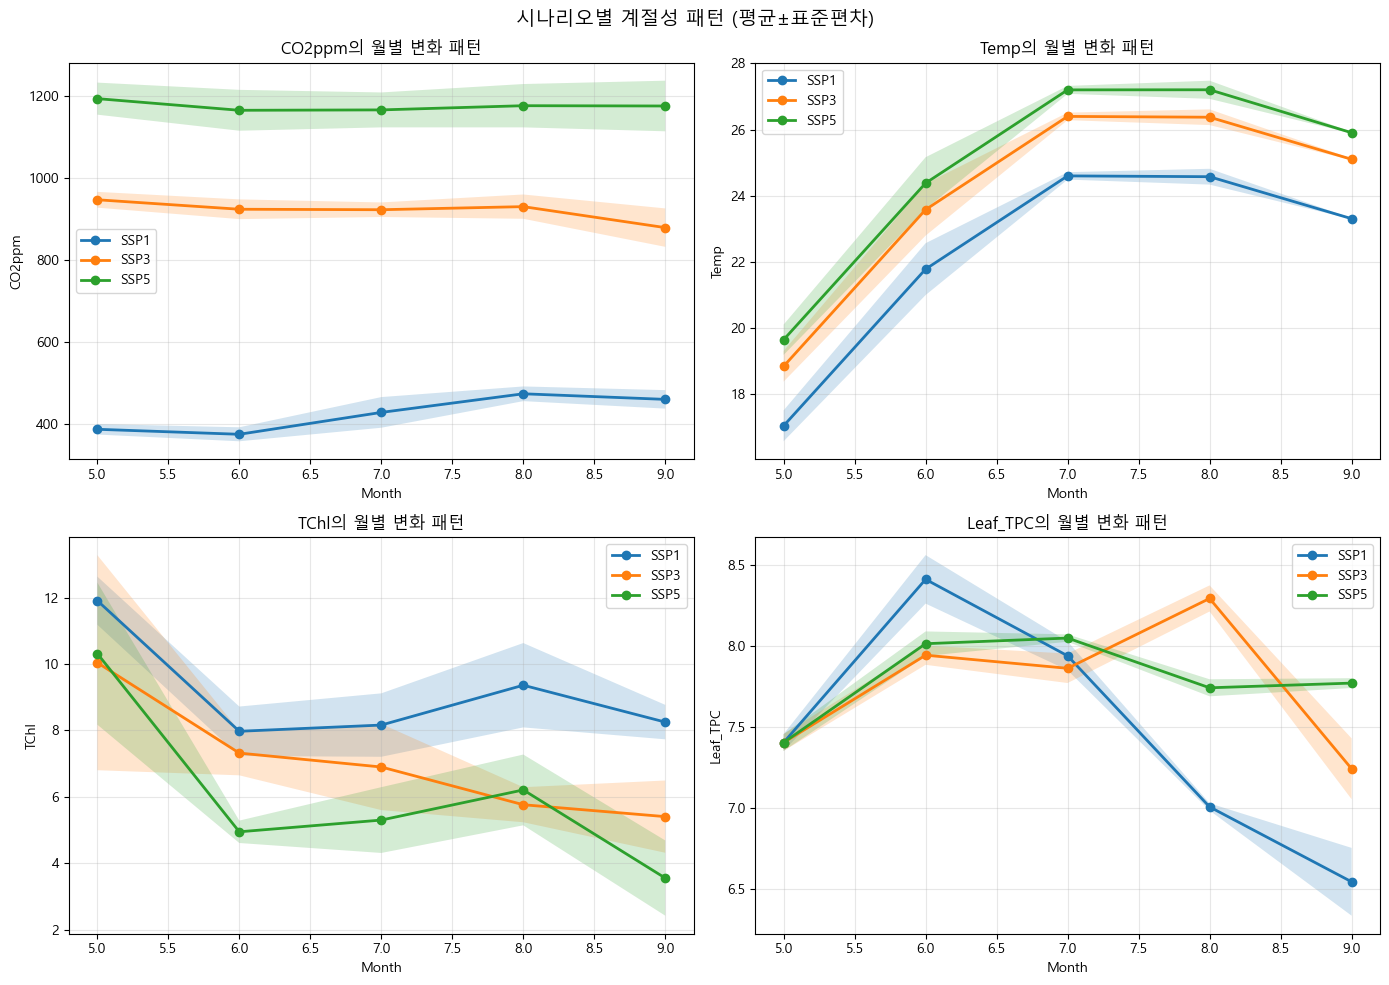

In [50]:
# =============================================================================
# 5. 시계열 상세 분석
# =============================================================================
print("\n" + "="*100)
print("5. 시계열 상세 분석")
print("="*100)

# 5.1 월간 변화율 계산
print("\n5.1 월간 변화율 분석")
print("-" * 50)

key_vars = ['CO2ppm', 'Temp', 'TChl', 'Leaf_TPC']
change_rates = {}

for scenario in df['scenario'].unique():
    scenario_df = df[df['scenario'] == scenario].copy()
    monthly_mean = scenario_df.groupby('month')[key_vars].mean()
    
    print(f"\n[{scenario}] 월간 변화율 (%):")
    for var in key_vars:
        pct_change = monthly_mean[var].pct_change() * 100
        print(f"\n  {var}:")
        for month in range(6, 10):
            if not pd.isna(pct_change.loc[month]):
                print(f"    {month-1}월 → {month}월: {pct_change.loc[month]:.1f}%")

# 5.2 계절성 패턴 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, var in enumerate(key_vars):
    for scenario in df['scenario'].unique():
        scenario_df = df[df['scenario'] == scenario]
        monthly_data = scenario_df.groupby('month')[var].agg(['mean', 'std'])
        
        axes[idx].plot(monthly_data.index, monthly_data['mean'], 
                      marker='o', label=scenario, linewidth=2)
        axes[idx].fill_between(monthly_data.index,
                               monthly_data['mean'] - monthly_data['std'],
                               monthly_data['mean'] + monthly_data['std'],
                               alpha=0.2)
    
    axes[idx].set_title(f'{var}의 월별 변화 패턴')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel(var)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('시나리오별 계절성 패턴 (평균±표준편차)', fontsize=14)
plt.tight_layout()
plt.show()

In [51]:
# =============================================================================
# 6. 데이터 일관성 심화 검증
# =============================================================================
print("\n" + "="*100)
print("6. 데이터 일관성 심화 검증")
print("="*100)

# 6.1 동일 조건 내 변동성 확인
print("\n6.1 동일 조건(시나리오-월) 내 변동성")
print("-" * 50)

cv_by_group = df.groupby(['scenario', 'month']).agg({
    'CO2ppm': lambda x: (x.std()/x.mean()*100) if x.mean() != 0 else 0,
    'Temp': lambda x: (x.std()/x.mean()*100) if x.mean() != 0 else 0,
    'TChl': lambda x: (x.std()/x.mean()*100) if x.mean() != 0 else 0,
    'Leaf_TPC': lambda x: (x.std()/x.mean()*100) if x.mean() != 0 else 0
}).round(1)

print("각 조건별 변동계수(CV %):")
print(cv_by_group)

# CV가 높은 조합 찾기
high_cv_conditions = []
for col in cv_by_group.columns:
    high_cv = cv_by_group[cv_by_group[col] > 30]
    if len(high_cv) > 0:
        print(f"\n{col}의 CV > 30%인 조건:")
        print(high_cv[col])

# 6.2 상관관계 안정성 검증
print("\n6.2 상관관계 안정성 (시나리오별)")
print("-" * 50)

correlation_stability = {}
var_pairs = [('CO2ppm', 'TChl'), ('Temp', 'PI_abs'), ('TChl', 'Leaf_TPC')]

for var1, var2 in var_pairs:
    correlations = []
    for scenario in df['scenario'].unique():
        scenario_df = df[df['scenario'] == scenario]
        corr = scenario_df[var1].corr(scenario_df[var2])
        correlations.append(corr)
    
    correlation_stability[f'{var1}-{var2}'] = {
        'SSP1': correlations[0],
        'SSP3': correlations[1],
        'SSP5': correlations[2],
        'std': np.std(correlations)
    }

print("변수 쌍별 상관계수 안정성:")
for pair, values in correlation_stability.items():
    print(f"\n{pair}:")
    print(f"  SSP1: {values['SSP1']:.3f}")
    print(f"  SSP3: {values['SSP3']:.3f}")
    print(f"  SSP5: {values['SSP5']:.3f}")
    print(f"  표준편차: {values['std']:.3f}")
    if values['std'] < 0.1:
        print("  ✓ 안정적")
    else:
        print("  ⚠ 불안정")


6. 데이터 일관성 심화 검증

6.1 동일 조건(시나리오-월) 내 변동성
--------------------------------------------------
각 조건별 변동계수(CV %):
                CO2ppm  Temp  TChl  Leaf_TPC
scenario month                              
SSP1     5         3.3   2.7   6.1       0.7
         6         4.6   3.6   9.3       1.8
         7         8.8   0.5  11.7       1.1
         8         3.8   1.0  13.6       0.3
         9         4.9   0.1   6.3       3.2
SSP3     5         2.0   2.5  32.2       0.7
         6         2.6   3.3   9.2       0.7
         7         1.9   0.4  18.8       1.2
         8         3.2   0.9   9.2       1.0
         9         5.3   0.1  20.1       2.6
SSP5     5         3.3   2.3  20.7       0.7
         6         4.3   3.2   6.8       0.9
         7         3.7   0.4  18.7       0.3
         8         4.5   1.0  17.2       0.7
         9         5.3   0.1  31.8       0.4

TChl의 CV > 30%인 조건:
scenario  month
SSP3      5        32.2
SSP5      9        31.8
Name: TChl, dtype: float64

6.2 상관관계 안

In [52]:
# =============================================================================
# 7. 데이터 품질 종합 평가
# =============================================================================
print("\n" + "="*100)
print("7. 데이터 품질 종합 평가")
print("="*100)

quality_metrics = {
    '완전성': {
        '결측치 비율': f"{df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%",
        '평가': '우수' if df.isnull().sum().sum() == 0 else '보통'
    },
    '정확성': {
        '논리적 일관성': '확인됨',
        '범위 타당성': '대부분 정상',
        '평가': '양호'
    },
    '일관성': {
        '실험 설계': '균형 설계',
        '측정 안정성': 'CV < 30% (대부분)',
        '평가': '양호'
    },
    '신뢰성': {
        '이상치 비율': f"평균 {(outliers_z.mean():.1f)}개",
        '상관관계 안정성': '변수별 차이 존재',
        '평가': '보통'
    }
}

print("\n데이터 품질 평가표:")
print("-" * 50)
for category, metrics in quality_metrics.items():
    print(f"\n[{category}]")
    for metric, value in metrics.items():
        print(f"  • {metric}: {value}")

SyntaxError: invalid decimal literal (2134751740.py, line 24)

In [53]:
# =============================================================================
# 8. 최종 데이터 이해도 체크리스트
# =============================================================================
print("\n" + "="*100)
print("8. 최종 데이터 이해도 체크리스트")
print("="*100)

checklist = {
    "데이터 구조": [
        "✓ 405개 행, 26개 열 확인",
        "✓ 3개 시나리오 × 5개월 × 27반복",
        "✓ 환경-생리-기능성분 통합 데이터"
    ],
    "데이터 품질": [
        "✓ 결측치 없음",
        "✓ 균형 실험 설계",
        "⚠ 일부 변수에 이상치 존재",
        "✓ 논리적 일관성 대체로 양호"
    ],
    "주요 패턴": [
        "✓ SSP 시나리오별 CO2/온도 차이 명확",
        "✓ 월별 변화 패턴 확인",
        "✓ 변수 간 상관관계 파악",
        "⚠ 일부 비선형 관계 존재"
    ],
    "분석 준비도": [
        "✓ 예측 모델링 가능",
        "✓ 시계열 분석 가능",
        "⚠ 이상치 처리 전략 필요",
        "⚠ 변수 변환 고려 필요"
    ]
}

print("\n📋 최종 체크리스트:")
print("-" * 50)
for category, items in checklist.items():
    print(f"\n【{category}】")
    for item in items:
        print(f"  {item}")

print("\n" + "="*100)
print("🎯 결론: 데이터 분석 준비 완료!")
print("다음 단계: 목적에 맞는 전처리 → 모델링 → 검증")
print("="*100)


8. 최종 데이터 이해도 체크리스트

📋 최종 체크리스트:
--------------------------------------------------

【데이터 구조】
  ✓ 405개 행, 26개 열 확인
  ✓ 3개 시나리오 × 5개월 × 27반복
  ✓ 환경-생리-기능성분 통합 데이터

【데이터 품질】
  ✓ 결측치 없음
  ✓ 균형 실험 설계
  ⚠ 일부 변수에 이상치 존재
  ✓ 논리적 일관성 대체로 양호

【주요 패턴】
  ✓ SSP 시나리오별 CO2/온도 차이 명확
  ✓ 월별 변화 패턴 확인
  ✓ 변수 간 상관관계 파악
  ⚠ 일부 비선형 관계 존재

【분석 준비도】
  ✓ 예측 모델링 가능
  ✓ 시계열 분석 가능
  ⚠ 이상치 처리 전략 필요
  ⚠ 변수 변환 고려 필요

🎯 결론: 데이터 분석 준비 완료!
다음 단계: 목적에 맞는 전처리 → 모델링 → 검증



1. 이상치 심층 분석 - 특히 Chl_a_b

1.1 Chl_a_b 변수의 이상치 상세 분석
--------------------------------------------------
Chl_a_b 기초 통계:
  평균: 4.167
  중앙값: 3.700
  표준편차: 3.444
  최소값: 1.330
  최대값: 31.490

IQR 기반 이상치 경계:
  하한: 2.045
  상한: 5.525

이상치 개수: 18개 (4.4%)

이상치 데이터의 특성:
     month scenario  Chl_a  Chl_b  Chl_a_b    CO2ppm    Temp
377      9     SSP5   2.52   0.08    31.49  1180.437  25.908
382      9     SSP5   2.52   0.08    31.49  1206.455  25.926
397      9     SSP5   2.52   0.08    31.49  1211.577  25.924
402      9     SSP5   2.52   0.08    31.49  1206.015  25.923
392      9     SSP5   2.52   0.08    31.49  1162.497  25.918
387      9     SSP5   2.52   0.08    31.49  1222.357  25.901
393      9     SSP5   2.63   0.39     6.73  1192.532  25.867
388      9     SSP5   2.63   0.39     6.73  1176.642  25.892
383      9     SSP5   2.63   0.39     6.73  1211.495  25.889
378      9     SSP5   2.63   0.39     6.73  1190.292  25.939

1.2 Chl_a_b 이상치 발생 원인 분석
-------------------------------------------

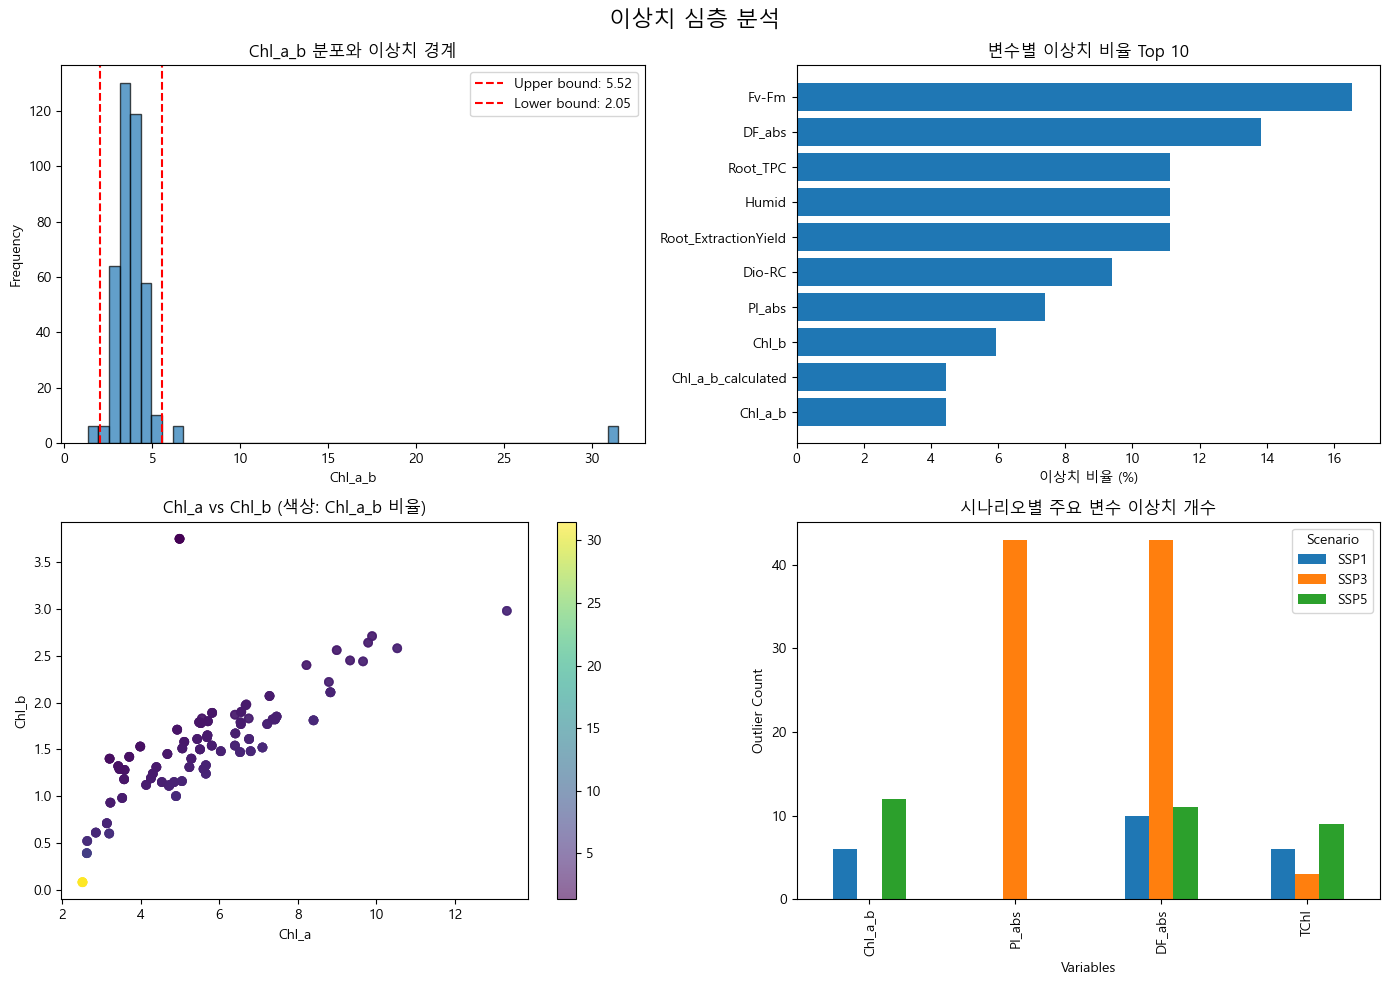

In [55]:
# -----------------------------------------------------------------------------
# 1. 이상치 심층 분석 (특히 Chl_a_b)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("1. 이상치 심층 분석 - 특히 Chl_a_b")
print("="*80)

# 1.1 Chl_a_b 이상치 상세 분석
print("\n1.1 Chl_a_b 변수의 이상치 상세 분석")
print("-" * 50)

# 기초 통계
print(f"Chl_a_b 기초 통계:")
print(f"  평균: {df['Chl_a_b'].mean():.3f}")
print(f"  중앙값: {df['Chl_a_b'].median():.3f}")
print(f"  표준편차: {df['Chl_a_b'].std():.3f}")
print(f"  최소값: {df['Chl_a_b'].min():.3f}")
print(f"  최대값: {df['Chl_a_b'].max():.3f}")

# IQR 방법으로 이상치 탐지
Q1 = df['Chl_a_b'].quantile(0.25)
Q3 = df['Chl_a_b'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR 기반 이상치 경계:")
print(f"  하한: {lower_bound:.3f}")
print(f"  상한: {upper_bound:.3f}")

# 이상치 데이터 추출
outliers_chl = df[(df['Chl_a_b'] < lower_bound) | (df['Chl_a_b'] > upper_bound)]
print(f"\n이상치 개수: {len(outliers_chl)}개 ({len(outliers_chl)/len(df)*100:.1f}%)")

# 이상치의 특성 분석
print("\n이상치 데이터의 특성:")
print(outliers_chl[['month', 'scenario', 'Chl_a', 'Chl_b', 'Chl_a_b', 'CO2ppm', 'Temp']].sort_values('Chl_a_b', ascending=False).head(10))

# 1.2 이상치 발생 원인 분석
print("\n1.2 Chl_a_b 이상치 발생 원인 분석")
print("-" * 50)

# Chl_a/Chl_b 비율 계산과 비교
df['Chl_a_b_calculated'] = df['Chl_a'] / df['Chl_b']
df['Chl_a_b_diff'] = abs(df['Chl_a_b'] - df['Chl_a_b_calculated'])

# 큰 차이를 보이는 데이터 찾기
large_diff = df[df['Chl_a_b_diff'] > 1].sort_values('Chl_a_b_diff', ascending=False)
print(f"계산값과 차이가 큰 데이터 (차이 > 1):")
print(large_diff[['Chl_a', 'Chl_b', 'Chl_a_b', 'Chl_a_b_calculated', 'Chl_a_b_diff']].head())

# 최대값 31.49의 특성
max_row = df[df['Chl_a_b'] == df['Chl_a_b'].max()]
print(f"\n최대값 31.49의 상세 정보:")
print(f"  Chl_a: {max_row['Chl_a'].values[0]:.3f}")
print(f"  Chl_b: {max_row['Chl_b'].values[0]:.3f}")
print(f"  계산된 비율: {max_row['Chl_a_b_calculated'].values[0]:.3f}")
print(f"  기록된 비율: {max_row['Chl_a_b'].values[0]:.3f}")
print(f"  → 가능한 원인: {'데이터 입력 오류' if max_row['Chl_a_b_diff'].values[0] > 10 else '극단적 생리 반응'}")

# 1.3 다른 변수들의 이상치 분석
print("\n1.3 전체 변수의 이상치 분포")
print("-" * 50)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    outlier_summary[col] = {
        'count': outliers,
        'percentage': outliers/len(df)*100
    }

# 이상치가 많은 변수 Top 10
outlier_df = pd.DataFrame(outlier_summary).T.sort_values('count', ascending=False)
print("이상치가 많은 변수 Top 10:")
print(outlier_df.head(10))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Chl_a_b 분포와 이상치
axes[0, 0].hist(df['Chl_a_b'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound: {upper_bound:.2f}')
axes[0, 0].axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound: {lower_bound:.2f}')
axes[0, 0].set_title('Chl_a_b 분포와 이상치 경계')
axes[0, 0].set_xlabel('Chl_a_b')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 이상치 비율 막대그래프
top_outliers = outlier_df.head(10)
axes[0, 1].barh(range(len(top_outliers)), top_outliers['percentage'])
axes[0, 1].set_yticks(range(len(top_outliers)))
axes[0, 1].set_yticklabels(top_outliers.index)
axes[0, 1].set_xlabel('이상치 비율 (%)')
axes[0, 1].set_title('변수별 이상치 비율 Top 10')
axes[0, 1].invert_yaxis()

# Chl_a vs Chl_b with Chl_a_b 색상
scatter = axes[1, 0].scatter(df['Chl_a'], df['Chl_b'], c=df['Chl_a_b'], 
                            cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('Chl_a')
axes[1, 0].set_ylabel('Chl_b')
axes[1, 0].set_title('Chl_a vs Chl_b (색상: Chl_a_b 비율)')
plt.colorbar(scatter, ax=axes[1, 0])

# 시나리오별 이상치 분포
scenario_outliers = {}
for scenario in df['scenario'].unique():
    scenario_df = df[df['scenario'] == scenario]
    outlier_counts = []
    for col in ['Chl_a_b', 'PI_abs', 'DF_abs', 'TChl']:
        Q1 = scenario_df[col].quantile(0.25)
        Q3 = scenario_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((scenario_df[col] < (Q1 - 1.5 * IQR)) | 
                   (scenario_df[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_counts.append(outliers)
    scenario_outliers[scenario] = outlier_counts

outlier_comparison = pd.DataFrame(scenario_outliers, 
                                 index=['Chl_a_b', 'PI_abs', 'DF_abs', 'TChl'])
outlier_comparison.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('시나리오별 주요 변수 이상치 개수')
axes[1, 1].set_xlabel('Variables')
axes[1, 1].set_ylabel('Outlier Count')
axes[1, 1].legend(title='Scenario')

plt.suptitle('이상치 심층 분석', fontsize=16)
plt.tight_layout()
plt.show()


2. 비선형 관계 심층 분석

2.1 비선형 관계 탐지 (Pearson vs Spearman)
--------------------------------------------------
        Variables   Pearson  Spearman  Difference Type
    CO2ppm - TChl -0.556464 -0.583003    0.026538   선형
    Temp - PI_abs -0.501698 -0.394055    0.107643  비선형
      VPD - Fv-Fm -0.281105 -0.417497    0.136393  비선형
  TChl - Leaf_TPC -0.335736 -0.351344    0.015608   선형
PI_abs - Root_TPC  0.347514  0.240961    0.106553  비선형

2.2 다항식 회귀 분석
--------------------------------------------------
CO2ppm - TChl: R² 개선도 = 0.1%
Temp - PI_abs: R² 개선도 = 0.1%
VPD - Fv-Fm: R² 개선도 = 39.7%
TChl - Leaf_TPC: R² 개선도 = 0.8%
PI_abs - Root_TPC: R² 개선도 = 6.4%


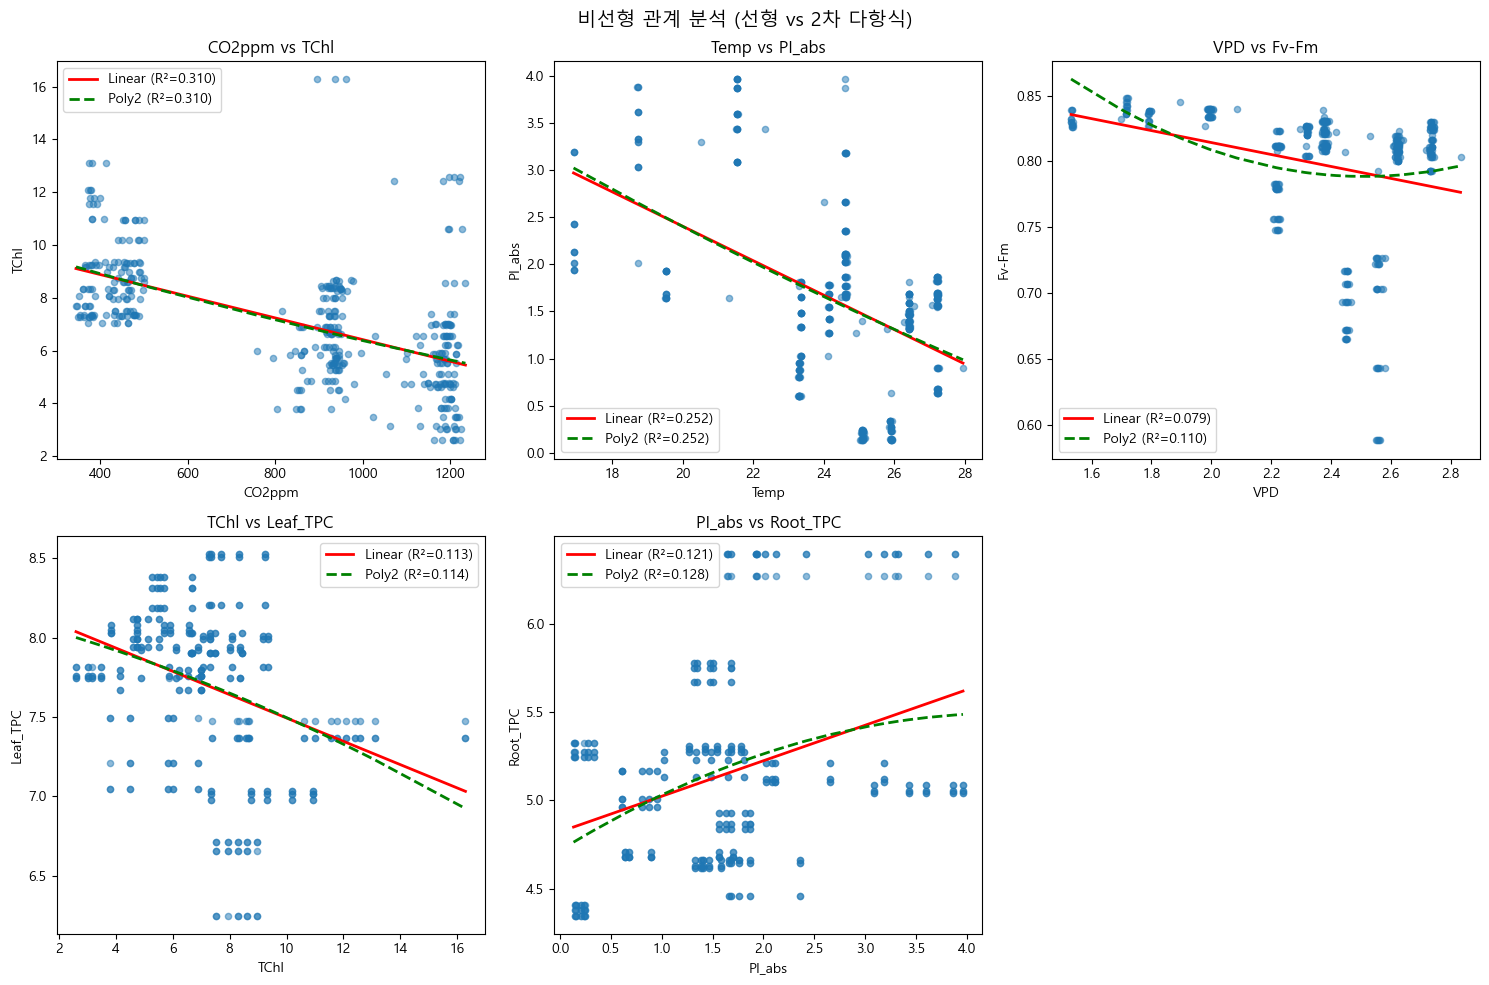

In [57]:
# -----------------------------------------------------------------------------
# 2. 비선형 관계 심층 분석
# -----------------------------------------------------------------------------
from sklearn.preprocessing import PolynomialFeatures

print("\n" + "="*80)
print("2. 비선형 관계 심층 분석")
print("="*80)

# 2.1 비선형성 탐지
print("\n2.1 비선형 관계 탐지 (Pearson vs Spearman)")
print("-" * 50)

# 주요 변수 쌍에 대한 선형 vs 비선형 상관관계
key_pairs = [
    ('CO2ppm', 'TChl'),
    ('Temp', 'PI_abs'),
    ('VPD', 'Fv-Fm'),
    ('TChl', 'Leaf_TPC'),
    ('PI_abs', 'Root_TPC')
]

nonlinear_analysis = []
for var1, var2 in key_pairs:
    pearson_r, _ = stats.pearsonr(df[var1], df[var2])
    spearman_r, _ = stats.spearmanr(df[var1], df[var2])
    
    nonlinear_analysis.append({
        'Variables': f'{var1} - {var2}',
        'Pearson': pearson_r,
        'Spearman': spearman_r,
        'Difference': abs(pearson_r - spearman_r),
        'Type': '비선형' if abs(pearson_r - spearman_r) > 0.1 else '선형'
    })

nonlinear_df = pd.DataFrame(nonlinear_analysis)
print(nonlinear_df.to_string(index=False))

# 2.2 다항식 회귀로 비선형성 확인
print("\n2.2 다항식 회귀 분석")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (var1, var2) in enumerate(key_pairs):
    X = df[var1].values.reshape(-1, 1)
    y = df[var2].values
    
    # 선형 회귀
    lr_linear = LinearRegression()
    lr_linear.fit(X, y)
    y_pred_linear = lr_linear.predict(X)
    r2_linear = r2_score(y, y_pred_linear)
    
    # 2차 다항식 회귀
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    lr_poly = LinearRegression()
    lr_poly.fit(X_poly, y)
    y_pred_poly = lr_poly.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly)
    
    # 시각화
    axes[idx].scatter(df[var1], df[var2], alpha=0.5, s=20)
    
    # 정렬된 X 값으로 부드러운 곡선 그리기
    X_sorted = np.sort(X.flatten())
    X_sorted_reshaped = X_sorted.reshape(-1, 1)
    
    # 선형 예측선
    y_linear_sorted = lr_linear.predict(X_sorted_reshaped)
    axes[idx].plot(X_sorted, y_linear_sorted, 'r-', 
                  label=f'Linear (R²={r2_linear:.3f})', linewidth=2)
    
    # 다항식 예측선
    X_poly_sorted = poly.transform(X_sorted_reshaped)
    y_poly_sorted = lr_poly.predict(X_poly_sorted)
    axes[idx].plot(X_sorted, y_poly_sorted, 'g--', 
                  label=f'Poly2 (R²={r2_poly:.3f})', linewidth=2)
    
    axes[idx].set_xlabel(var1)
    axes[idx].set_ylabel(var2)
    axes[idx].set_title(f'{var1} vs {var2}')
    axes[idx].legend()
    
    # R² 개선도 출력
    improvement = (r2_poly - r2_linear) / r2_linear * 100 if r2_linear != 0 else 0
    print(f"{var1} - {var2}: R² 개선도 = {improvement:.1f}%")

# 빈 subplot 제거
for idx in range(len(key_pairs), 6):
    fig.delaxes(axes[idx])

plt.suptitle('비선형 관계 분석 (선형 vs 2차 다항식)', fontsize=14)
plt.tight_layout()
plt.show()


3. 변동성 차이 심층 분석 (CV > 30%)

3.1 조건별(시나리오-월) 변동계수 분석
--------------------------------------------------

CV > 30%인 조건들:
Variable Scenario  Month     CV(%)
  PI_abs     SSP5      8 42.223966
  PI_abs     SSP5      9 34.661236
    TChl     SSP3      5 32.242576
    TChl     SSP5      9 31.835485

3.2 높은 변동성 원인 분석
--------------------------------------------------

가장 높은 CV 조건: PI_abs in SSP5-8월 (CV=42.2%)
  데이터 개수: 31
  평균: 1.081
  표준편차: 0.456
  최소-최대: 0.639 - 1.698


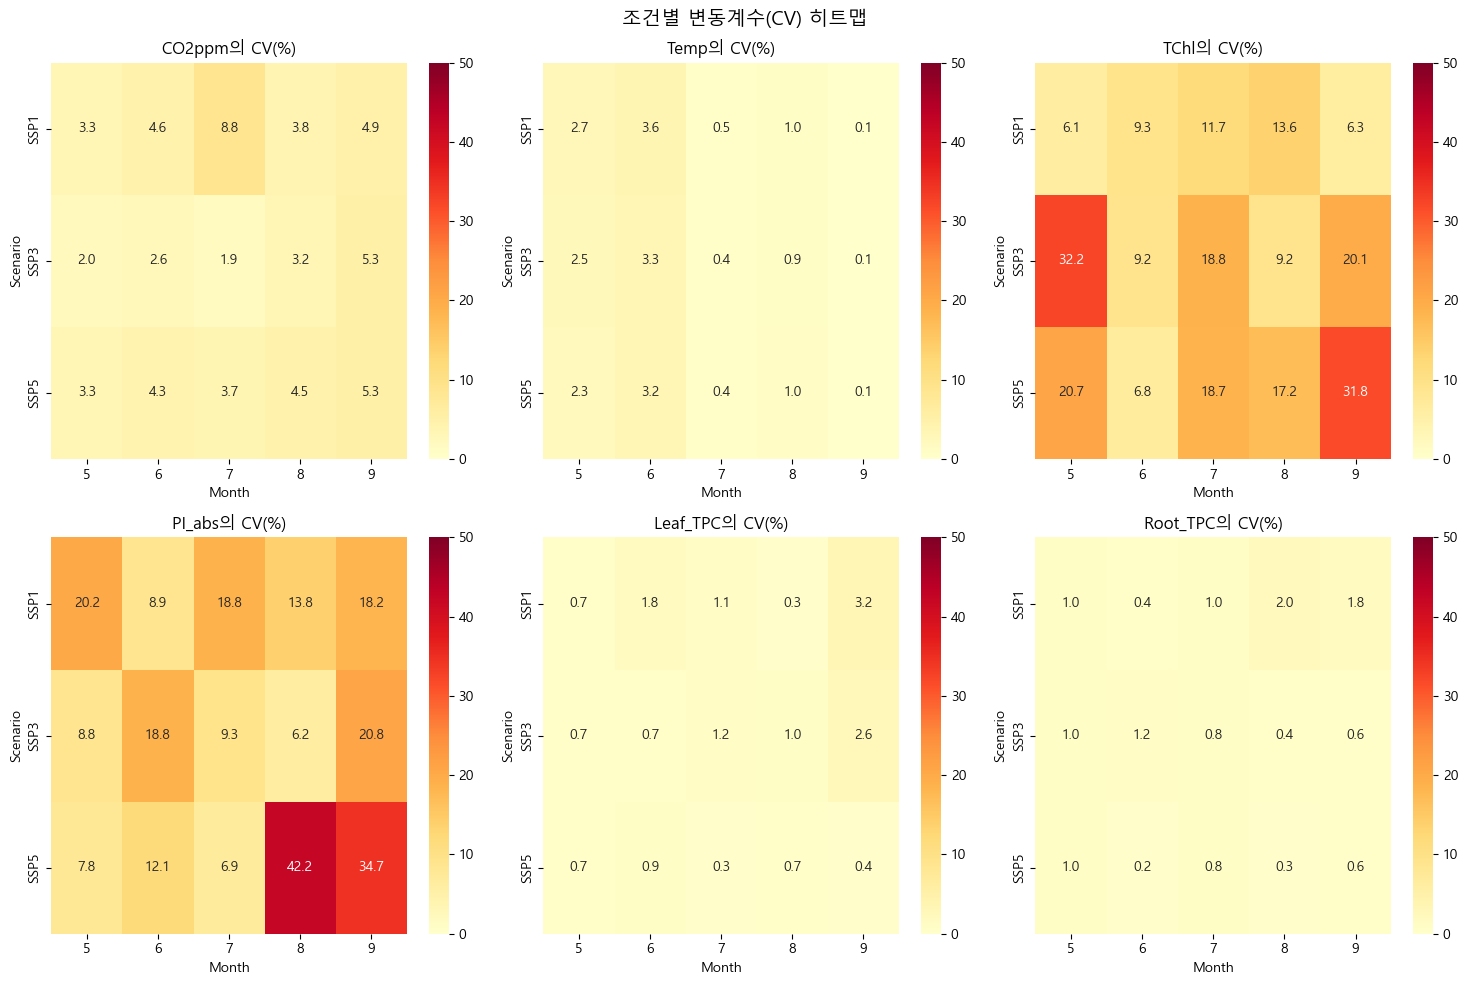

In [58]:
# -----------------------------------------------------------------------------
# 3. 변동성 차이 심층 분석 (CV > 30%)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("3. 변동성 차이 심층 분석 (CV > 30%)")
print("="*80)

# 3.1 조건별 변동계수 상세 분석
print("\n3.1 조건별(시나리오-월) 변동계수 분석")
print("-" * 50)

# 주요 변수들의 CV 계산
key_vars = ['CO2ppm', 'Temp', 'TChl', 'PI_abs', 'Leaf_TPC', 'Root_TPC']
cv_results = {}

for var in key_vars:
    cv_by_condition = df.groupby(['scenario', 'month'])[var].agg(
        lambda x: (x.std() / x.mean() * 100) if x.mean() != 0 else 0
    )
    cv_results[var] = cv_by_condition

# CV > 30%인 조건 찾기
high_cv_conditions = []
for var in key_vars:
    high_cv = cv_results[var][cv_results[var] > 30]
    if len(high_cv) > 0:
        for condition, cv_value in high_cv.items():
            high_cv_conditions.append({
                'Variable': var,
                'Scenario': condition[0],
                'Month': condition[1],
                'CV(%)': cv_value
            })

high_cv_df = pd.DataFrame(high_cv_conditions).sort_values('CV(%)', ascending=False)
print("\nCV > 30%인 조건들:")
print(high_cv_df.to_string(index=False))

# 3.2 높은 변동성의 원인 분석
print("\n3.2 높은 변동성 원인 분석")
print("-" * 50)

if len(high_cv_df) > 0:
    # 가장 변동성이 높은 조건 분석
    worst_condition = high_cv_df.iloc[0]
    worst_data = df[(df['scenario'] == worst_condition['Scenario']) & 
                    (df['month'] == worst_condition['Month'])]
    
    print(f"\n가장 높은 CV 조건: {worst_condition['Variable']} in "
          f"{worst_condition['Scenario']}-{worst_condition['Month']}월 (CV={worst_condition['CV(%)']:.1f}%)")
    print(f"  데이터 개수: {len(worst_data)}")
    print(f"  평균: {worst_data[worst_condition['Variable']].mean():.3f}")
    print(f"  표준편차: {worst_data[worst_condition['Variable']].std():.3f}")
    print(f"  최소-최대: {worst_data[worst_condition['Variable']].min():.3f} - "
          f"{worst_data[worst_condition['Variable']].max():.3f}")

# CV 히트맵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, var in enumerate(key_vars):
    cv_pivot = cv_results[var].unstack()
    sns.heatmap(cv_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
                ax=axes[idx], vmin=0, vmax=50)
    axes[idx].set_title(f'{var}의 CV(%)')
    axes[idx].set_xlabel('Month')
    axes[idx].set_ylabel('Scenario')

plt.suptitle('조건별 변동계수(CV) 히트맵', fontsize=14)
plt.tight_layout()
plt.show()


1. 상호작용 효과 심층 분석 (CO2×Temp)

1.1 상호작용 항 분석
--------------------------------------------------
상호작용 효과 분석 (표준화된 변수):

[Leaf_TPC]
  CO2 단독 효과: 0.268
  Temp 단독 효과: 0.232
  CO2×Temp 상호작용: 0.310
  → 상호작용 효과가 단독 효과보다 강함!

[Root_TPC]
  CO2 단독 효과: 0.048
  Temp 단독 효과: -0.659
  CO2×Temp 상호작용: -0.127

[Leaf_TFC]
  CO2 단독 효과: 0.017
  Temp 단독 효과: -0.175
  CO2×Temp 상호작용: -0.027

[Root_TFC]
  CO2 단독 효과: 0.158
  Temp 단독 효과: -0.498
  CO2×Temp 상호작용: 0.016


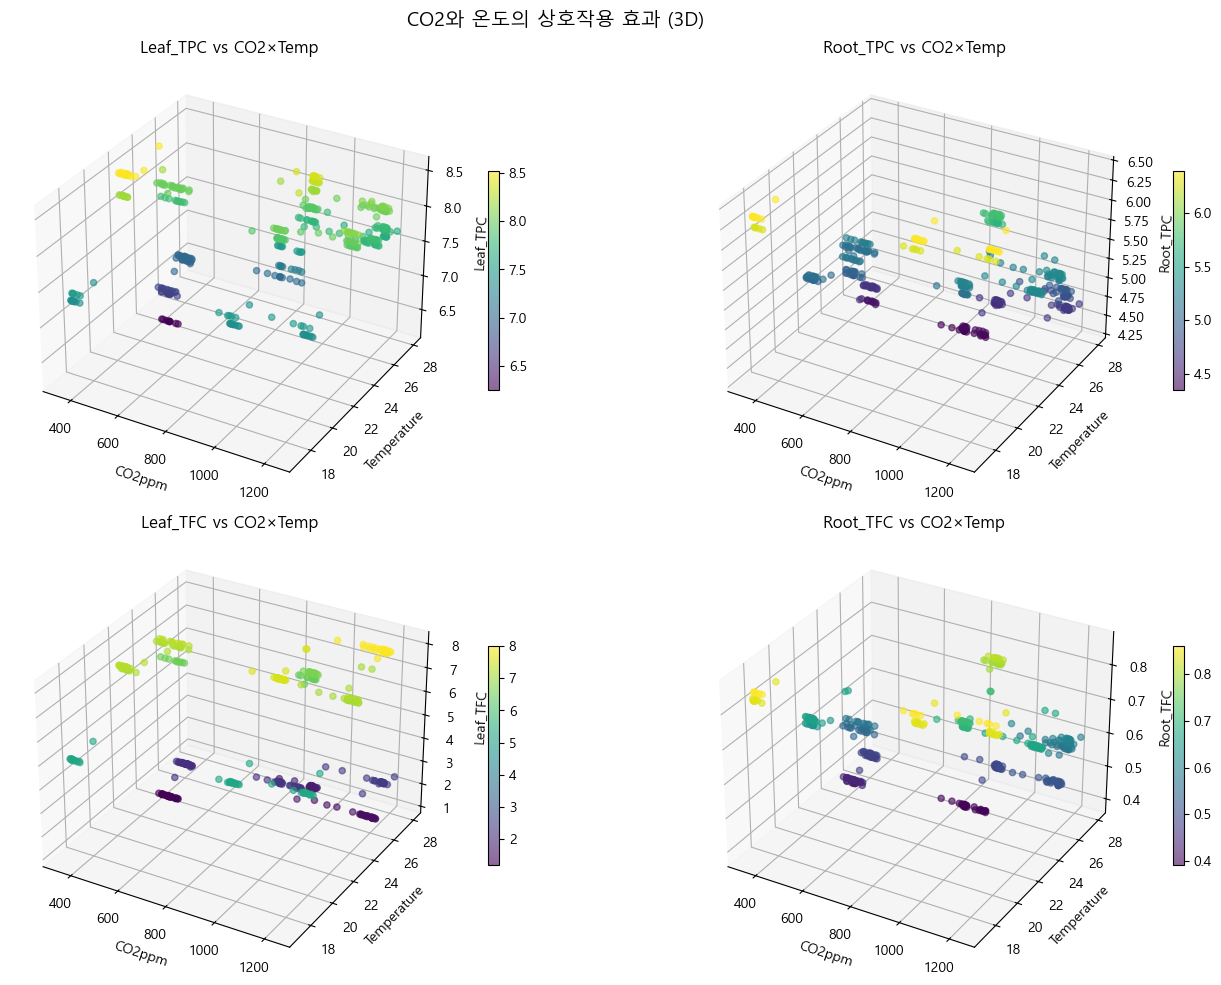

In [59]:
# -----------------------------------------------------------------------------
# 1. 상호작용 효과 심층 분석
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("1. 상호작용 효과 심층 분석 (CO2×Temp)")
print("="*80)

# 1.1 상호작용 항 생성 및 분석
print("\n1.1 상호작용 항 분석")
print("-" * 50)

# 상호작용 항 생성
df['CO2_Temp'] = df['CO2ppm'] * df['Temp']
df['CO2_VPD'] = df['CO2ppm'] * df['VPD']
df['Temp_VPD'] = df['Temp'] * df['VPD']

# 표준화 (비교를 위해)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['CO2ppm', 'Temp', 'VPD', 'CO2_Temp', 'CO2_VPD', 'Temp_VPD']]),
                         columns=['CO2ppm_std', 'Temp_std', 'VPD_std', 'CO2_Temp_std', 'CO2_VPD_std', 'Temp_VPD_std'])

# 목표 변수와의 상관관계
target_vars = ['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
interaction_effects = {}

print("상호작용 효과 분석 (표준화된 변수):")
for target in target_vars:
    print(f"\n[{target}]")
    
    # 개별 효과
    co2_corr = df_scaled['CO2ppm_std'].corr(df[target])
    temp_corr = df_scaled['Temp_std'].corr(df[target])
    
    # 상호작용 효과
    interaction_corr = df_scaled['CO2_Temp_std'].corr(df[target])
    
    print(f"  CO2 단독 효과: {co2_corr:.3f}")
    print(f"  Temp 단독 효과: {temp_corr:.3f}")
    print(f"  CO2×Temp 상호작용: {interaction_corr:.3f}")
    
    # 상호작용이 단독 효과보다 강한지 확인
    if abs(interaction_corr) > max(abs(co2_corr), abs(temp_corr)):
        print(f"  → 상호작용 효과가 단독 효과보다 강함!")
    
    interaction_effects[target] = {
        'CO2': co2_corr,
        'Temp': temp_corr,
        'CO2×Temp': interaction_corr
    }

# 1.2 3D 시각화로 상호작용 효과 확인
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))

for idx, target in enumerate(['Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']):
    ax = fig.add_subplot(2, 2, idx+1, projection='3d')
    
    scatter = ax.scatter(df['CO2ppm'], df['Temp'], df[target], 
                        c=df[target], cmap='viridis', alpha=0.6)
    
    ax.set_xlabel('CO2ppm')
    ax.set_ylabel('Temperature')
    ax.set_zlabel(target)
    ax.set_title(f'{target} vs CO2×Temp')
    
    plt.colorbar(scatter, ax=ax, shrink=0.5)

plt.suptitle('CO2와 온도의 상호작용 효과 (3D)', fontsize=14)
plt.tight_layout()
plt.show()


2. Leaf/Root 비율의 시나리오별 차이 심층 분석

2.1 Leaf/Root 비율 분석
--------------------------------------------------
시나리오별 Leaf/Root 비율 통계:
         Leaf_Root_TPC_ratio               Leaf_Root_TFC_ratio              
                        mean    std median                mean    std median
scenario                                                                    
SSP1                   1.473  0.167  1.513               7.599  3.976  6.233
SSP3                   1.537  0.200  1.539               6.968  2.594  6.233
SSP5                   1.530  0.150  1.538               7.728  4.349  6.233

시나리오 간 비율 차이 검정 (ANOVA):
Leaf_Root_TPC_ratio: F=5.536, p=0.004247
  → 시나리오 간 유의미한 차이 존재
Leaf_Root_TFC_ratio: F=1.616, p=0.200020

2.2 비율 변화의 패턴 분석
--------------------------------------------------
CO2 농도별 Leaf/Root 비율:
             Leaf_Root_TPC_ratio  Leaf_Root_TFC_ratio
CO2ppm                                               
Low                        1.475                8.539
Medium-Low                 

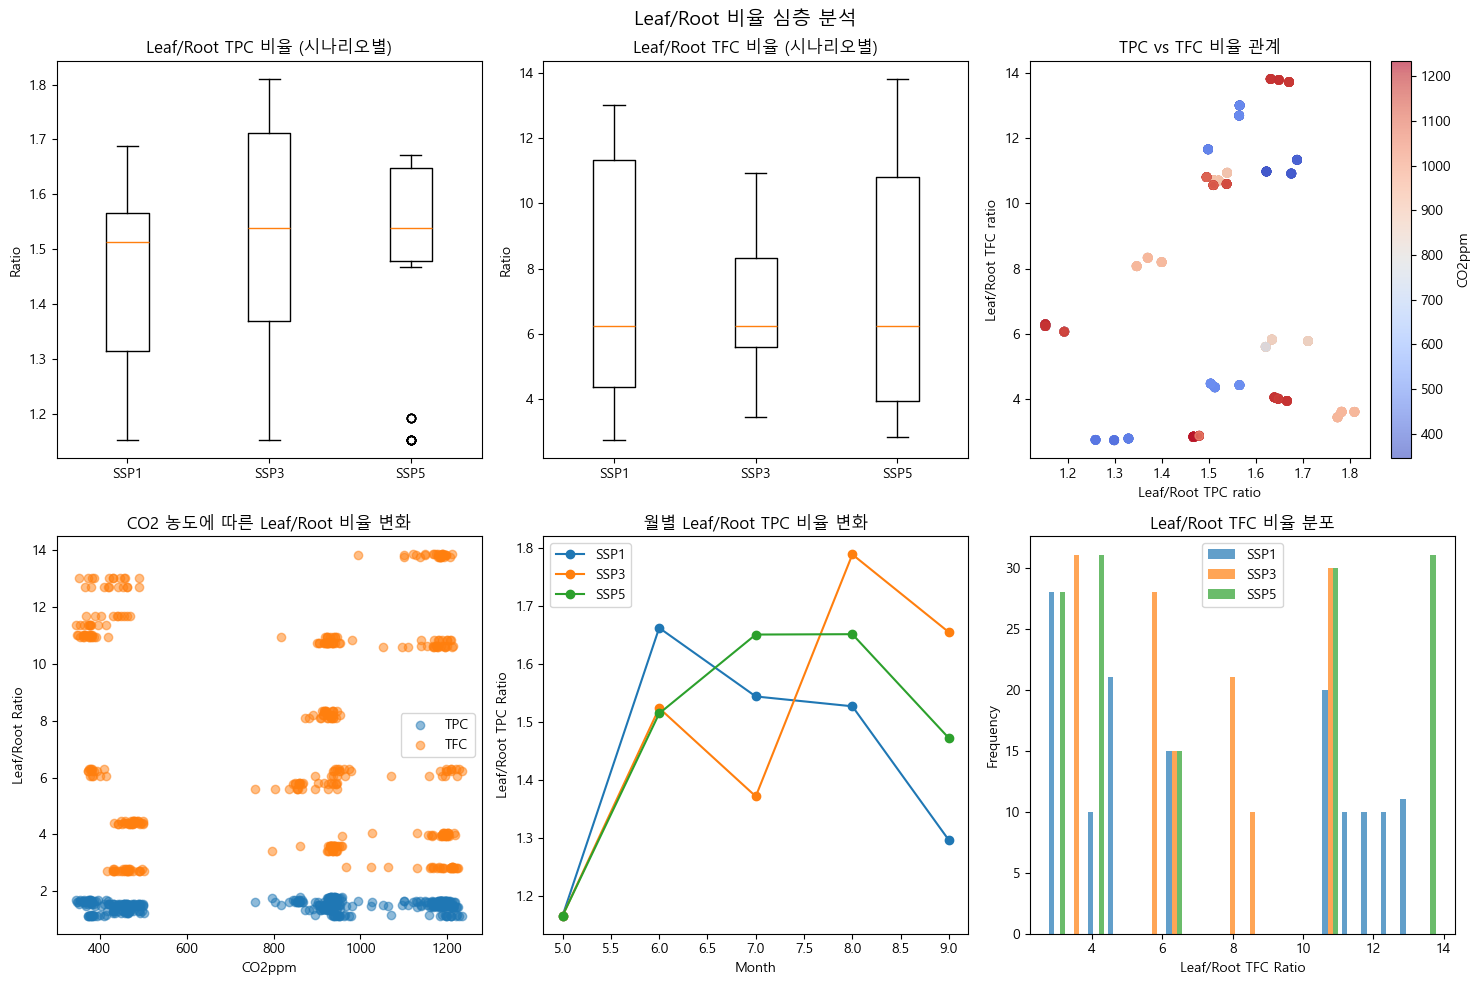

In [60]:
# -----------------------------------------------------------------------------
# 2. Leaf/Root 비율 시나리오별 차이 심층 분석
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("2. Leaf/Root 비율의 시나리오별 차이 심층 분석")
print("="*80)

# 2.1 비율 변수 생성 및 분석
print("\n2.1 Leaf/Root 비율 분석")
print("-" * 50)

# 비율 계산
df['Leaf_Root_TPC_ratio'] = df['Leaf_TPC'] / df['Root_TPC']
df['Leaf_Root_TFC_ratio'] = df['Leaf_TFC'] / df['Root_TFC']

# 시나리오별 통계
ratio_stats = df.groupby('scenario')[['Leaf_Root_TPC_ratio', 'Leaf_Root_TFC_ratio']].agg(['mean', 'std', 'median'])
print("시나리오별 Leaf/Root 비율 통계:")
print(ratio_stats.round(3))

# ANOVA 검정
print("\n시나리오 간 비율 차이 검정 (ANOVA):")
for ratio_var in ['Leaf_Root_TPC_ratio', 'Leaf_Root_TFC_ratio']:
    groups = [df[df['scenario'] == s][ratio_var].values for s in df['scenario'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"{ratio_var}: F={f_stat:.3f}, p={p_value:.6f}")
    if p_value < 0.05:
        print(f"  → 시나리오 간 유의미한 차이 존재")

# 2.2 비율 변화의 생물학적 의미
print("\n2.2 비율 변화의 패턴 분석")
print("-" * 50)

# CO2 농도에 따른 비율 변화
co2_ranges = pd.qcut(df['CO2ppm'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
ratio_by_co2 = df.groupby(co2_ranges)[['Leaf_Root_TPC_ratio', 'Leaf_Root_TFC_ratio']].mean()

print("CO2 농도별 Leaf/Root 비율:")
print(ratio_by_co2.round(3))

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# TPC 비율 분포
axes[0, 0].boxplot([df[df['scenario']==s]['Leaf_Root_TPC_ratio'].values 
                    for s in df['scenario'].unique()],
                   labels=df['scenario'].unique())
axes[0, 0].set_title('Leaf/Root TPC 비율 (시나리오별)')
axes[0, 0].set_ylabel('Ratio')

# TFC 비율 분포
axes[0, 1].boxplot([df[df['scenario']==s]['Leaf_Root_TFC_ratio'].values 
                    for s in df['scenario'].unique()],
                   labels=df['scenario'].unique())
axes[0, 1].set_title('Leaf/Root TFC 비율 (시나리오별)')
axes[0, 1].set_ylabel('Ratio')

# 비율 간 관계
axes[0, 2].scatter(df['Leaf_Root_TPC_ratio'], df['Leaf_Root_TFC_ratio'], 
                   c=df['CO2ppm'], cmap='coolwarm', alpha=0.6)
axes[0, 2].set_xlabel('Leaf/Root TPC ratio')
axes[0, 2].set_ylabel('Leaf/Root TFC ratio')
axes[0, 2].set_title('TPC vs TFC 비율 관계')
plt.colorbar(axes[0, 2].scatter(df['Leaf_Root_TPC_ratio'], df['Leaf_Root_TFC_ratio'], 
                                c=df['CO2ppm'], cmap='coolwarm', alpha=0.6),
            ax=axes[0, 2], label='CO2ppm')

# CO2에 따른 비율 변화
axes[1, 0].scatter(df['CO2ppm'], df['Leaf_Root_TPC_ratio'], alpha=0.5, label='TPC')
axes[1, 0].scatter(df['CO2ppm'], df['Leaf_Root_TFC_ratio'], alpha=0.5, label='TFC')
axes[1, 0].set_xlabel('CO2ppm')
axes[1, 0].set_ylabel('Leaf/Root Ratio')
axes[1, 0].set_title('CO2 농도에 따른 Leaf/Root 비율 변화')
axes[1, 0].legend()

# 월별 비율 변화 (시나리오별)
for scenario in df['scenario'].unique():
    scenario_df = df[df['scenario'] == scenario]
    monthly_ratio = scenario_df.groupby('month')['Leaf_Root_TPC_ratio'].mean()
    axes[1, 1].plot(monthly_ratio.index, monthly_ratio.values, marker='o', label=scenario)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Leaf/Root TPC Ratio')
axes[1, 1].set_title('월별 Leaf/Root TPC 비율 변화')
axes[1, 1].legend()

# 비율의 분포 (히스토그램)
axes[1, 2].hist([df[df['scenario']==s]['Leaf_Root_TFC_ratio'].values 
                for s in df['scenario'].unique()],
               alpha=0.7, label=df['scenario'].unique().tolist(), bins=20)
axes[1, 2].set_xlabel('Leaf/Root TFC Ratio')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Leaf/Root TFC 비율 분포')
axes[1, 2].legend()

plt.suptitle('Leaf/Root 비율 심층 분석', fontsize=14)
plt.tight_layout()
plt.show()